# Data Analysis: Transactions and Seller Marketing Insights in Olist

In [1]:
from IPython.display import Image

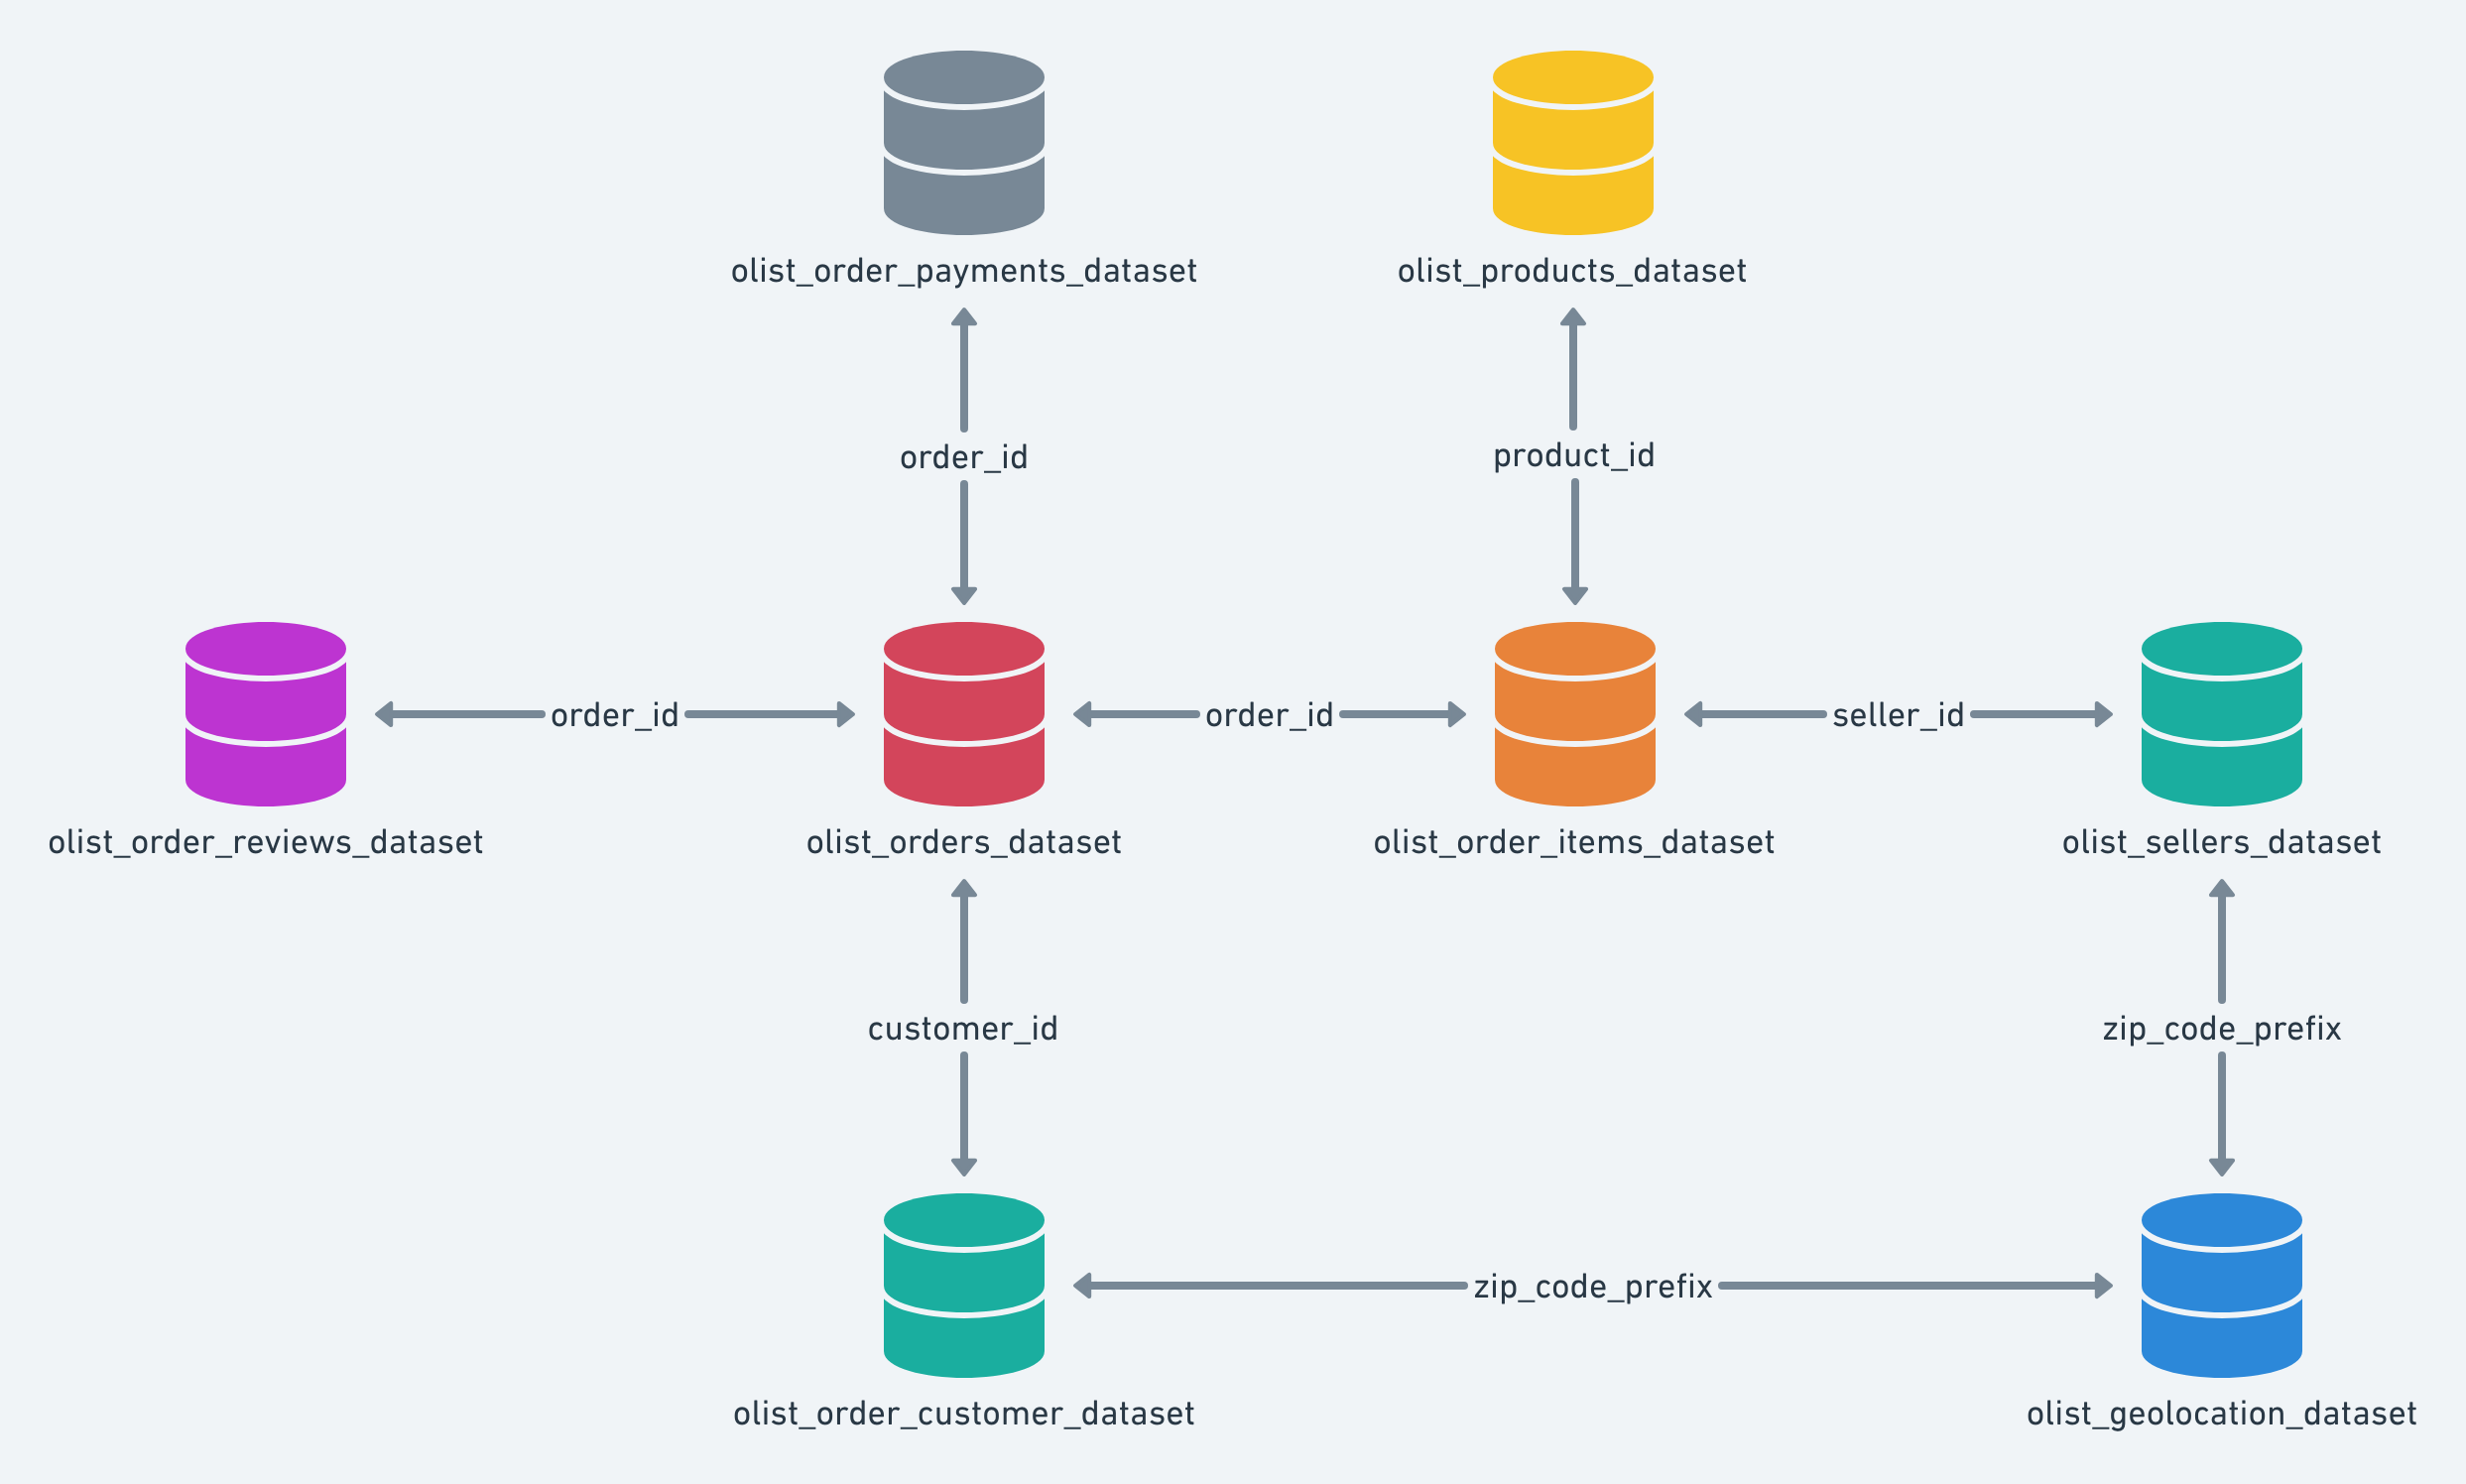

In [2]:
Image('data-schema.png')

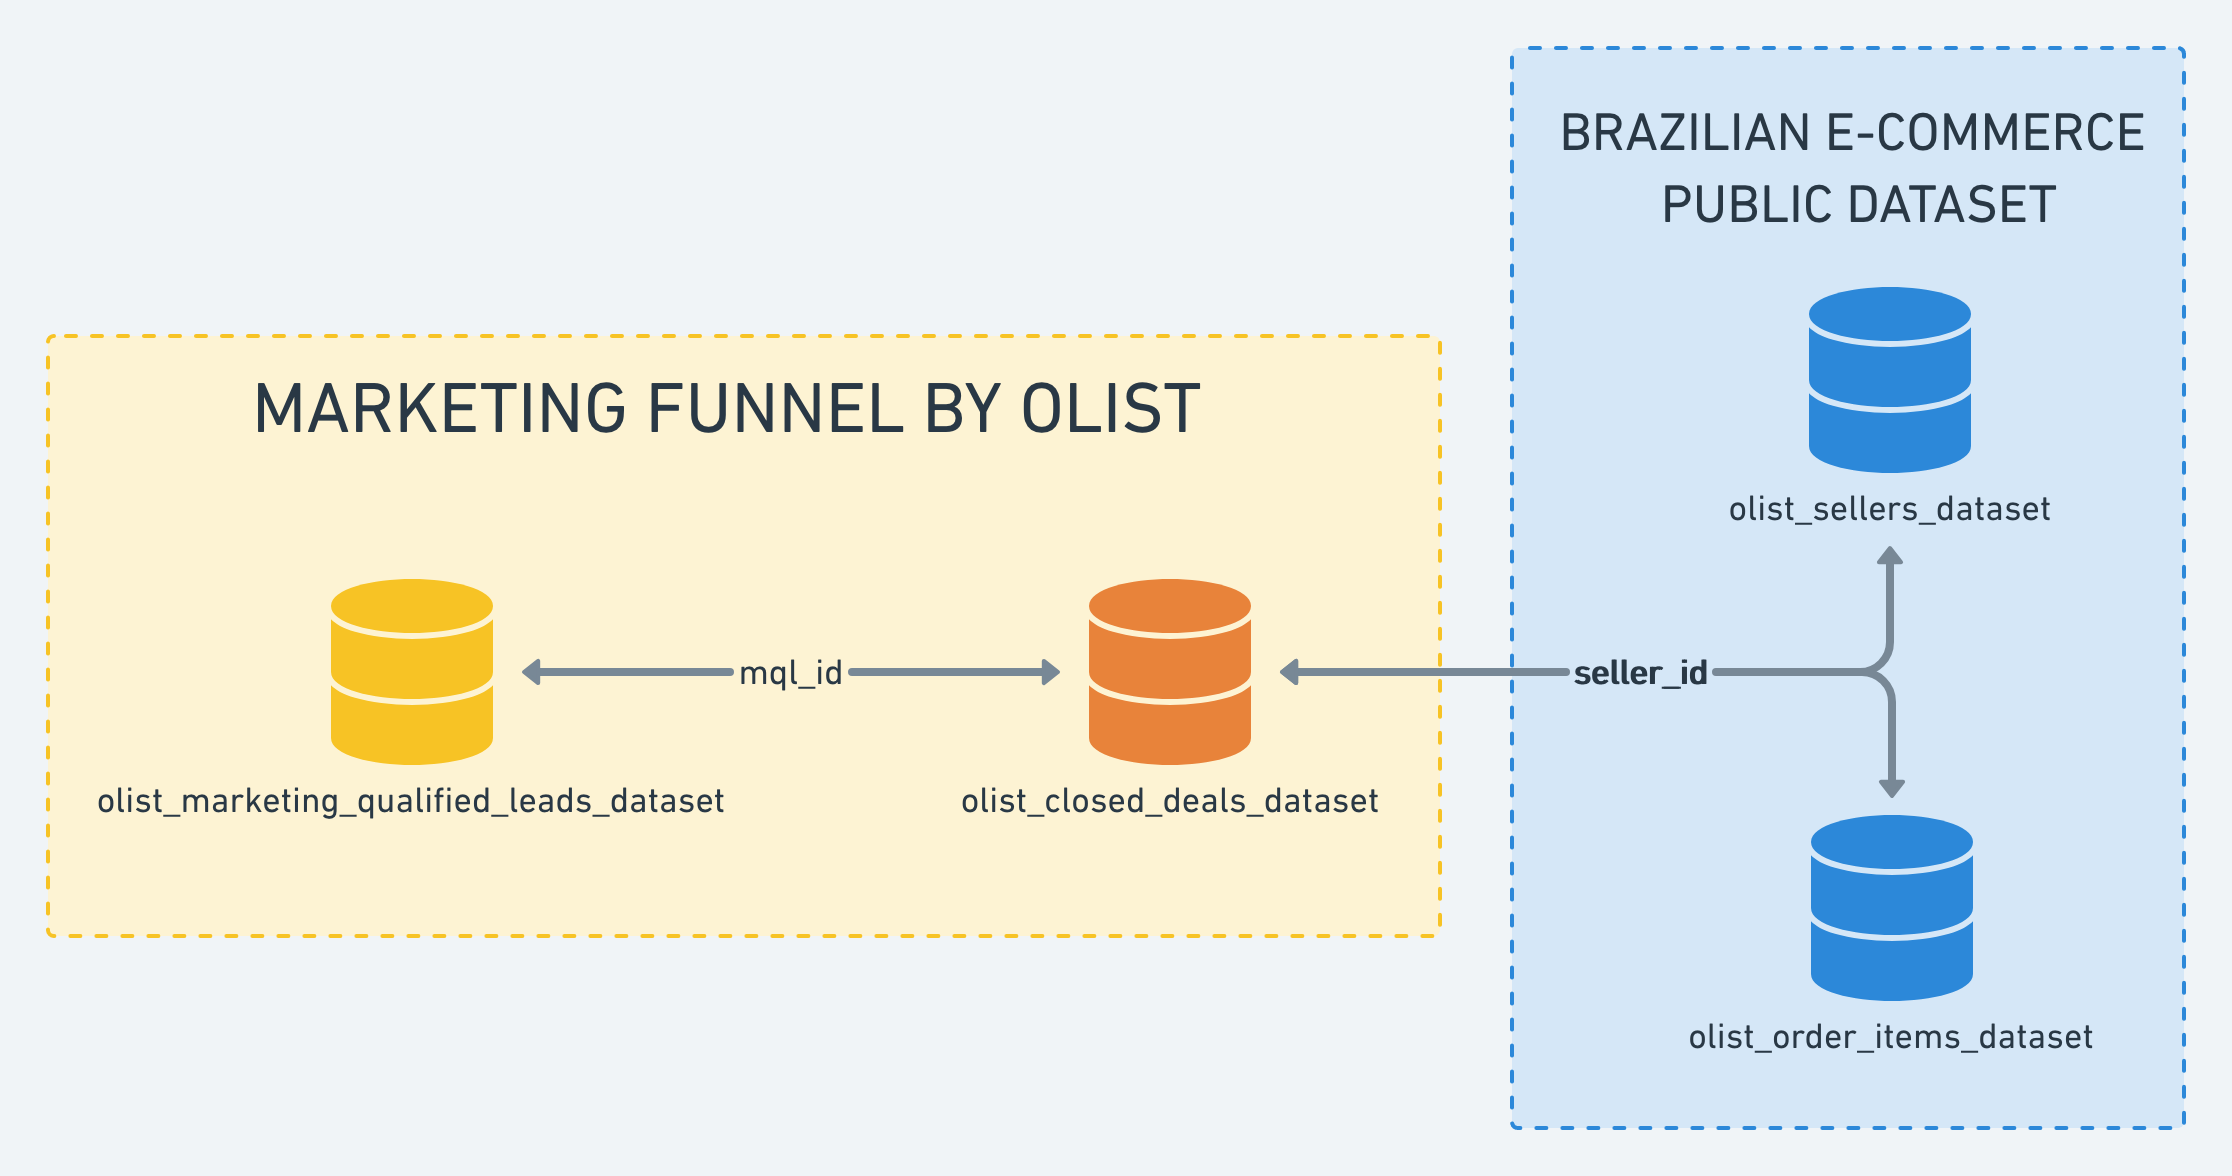

In [3]:
Image('data-schema-2.png')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import seaborn as sns
import datetime

pd.options.display.max_columns = None # Display all columns
pd.options.mode.copy_on_write  = True # Copy on writing new columns

In [5]:
df         = pd.read_csv('olist_sales.csv')
df_sellers = pd.read_csv('olist_marketing_funnel.csv')

In [6]:
# Changing types of date columns
date_cols = [
    'order_purchase_timestamp', 'order_approved_at',
    'order_delivered_carrier_date', 'order_delivered_customer_date',
    'order_estimated_delivery_date', 'shipping_limit_date',
    'review_creation_date', 'review_answer_timestamp']

for col in date_cols:
    df[col] = pd.to_datetime(df[col], format='mixed')
    
# Changing columns of date types
for sellers_col in ['first_contact_date', 'won_date']:
    df_sellers[sellers_col] = pd.to_datetime(df_sellers[sellers_col])

In [7]:
df.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_item_id                           float64
product_id                               object
seller_id                                object
shipping_limit_date              datetime64[ns]
price                                   float64
freight_value                           float64
payment_sequential                      float64
payment_type                             object
payment_installments                    float64
payment_value                           float64
review_id                                object
review_score                            float64
review_comment_title                    

In [8]:
df_sellers.dtypes

mql_id                                   object
first_contact_date               datetime64[ns]
landing_page_id                          object
origin                                   object
seller_id                                object
sdr_id                                   object
sr_id                                    object
won_date                         datetime64[ns]
business_segment                         object
lead_type                                object
lead_behaviour_profile                   object
has_company                              object
has_gtin                                 object
average_stock                            object
business_type                            object
declared_product_catalog_size           float64
declared_monthly_revenue                float64
seller_zip_code_prefix                  float64
seller_city                              object
seller_state                             object
num_order                               

## Data Analysis: Business Mode

Here we'll analyze the recurring customers in both the past quarter and the past year as an early indicator to check. Here's a guideline to look for to know your customer from a book Lean Analytics (2013):

| E-Commerce Business Mode | Annual Repurchase Rule | Quarterly Repurchase Rule | Description |
| --- | --- | --- | --- |
| **Acquisition Mode** | < 40%  |  1 - 15% | Customers mostly buy for items once, focus more on customer acquisition |
| **Hybrid Mode**     | 40-60% | 15 - 30% | Average customer will buy 2-2.5 times a year--focus on both acquisiton and increasing purchase frequency |
| **Loyalty Mode**    | > 60%  |    >30%  | Customers on average often purchase in the company, so focus on encouraging loyal clients to buy more frequently. |

Let's conduct analysis of returning customers per quarter and new customers per year. We'll create a function with input of date granularity, with output as a heatmap for cohort analysis of retention rate.

In [9]:
df_cohort_q = df.loc[:, ['customer_unique_id', 'order_purchase_timestamp']]

df_cohort_q['cohort_date'] = (
    df_cohort_q.groupby('customer_unique_id')
    ['order_purchase_timestamp']
    .transform('min').dt.to_period('Q')
)

df_cohort_q['quarter_period'] = (
    df_cohort_q['order_purchase_timestamp'].dt.to_period('Q'))

In [10]:
df_cohort_q

customer_unique_id order_purchase_timestamp cohort_date  \
0       7c396fd4830fd04220f754e42b4e5bff      2017-10-02 10:56:00      2017Q3   
1       7c396fd4830fd04220f754e42b4e5bff      2017-10-02 10:56:00      2017Q3   
2       7c396fd4830fd04220f754e42b4e5bff      2017-10-02 10:56:00      2017Q3   
3       af07308b275d755c9edb36a90c618231      2018-07-24 20:41:00      2018Q3   
4       3a653a41f6f9fc3d2a113cf8398680e8      2018-08-08 08:38:00      2018Q3   
...                                  ...                      ...         ...   
115715  da62f9e57a76d978d02ab5362c509660      2018-02-06 12:58:00      2018Q1   
115716  737520a9aad80b3fbbdad19b66b37b30      2017-08-27 14:46:00      2017Q3   
115717  5097a5312c8b157bb7be58ae360ef43c      2018-01-08 21:28:00      2018Q1   
115718  5097a5312c8b157bb7be58ae360ef43c      2018-01-08 21:28:00      2018Q1   
115719  60350aa974b26ff12caad89e55993bd6      2018-03-08 20:57:00      2018Q1   

       quarter_period  
0              2017Q4  
1              2017Q4  
2              2017Q4  
3              2018Q3  
4              2018Q3  
...               ...  
115715         2018Q1  
115716         2017Q3  
115717         2018Q1  
115718         2018Q1  
115719         2018Q1  

[115720 rows x 4 columns]

In [11]:
df_cohort_q = df_cohort_q.groupby(['cohort_date',
    'quarter_period'], as_index=False).agg(
    n_customers = ('customer_unique_id', 'nunique'))

df_cohort_q['elapsed_period'] = (
    df_cohort_q['quarter_period'] - 
    df_cohort_q['cohort_date']).apply(lambda x: x.n)

In [12]:
df_cohort_q

cohort_date quarter_period  n_customers  elapsed_period
0       2016Q4         2016Q4          263               0
1       2016Q4         2017Q1            1               1
2       2016Q4         2017Q2            1               2
3       2016Q4         2017Q3            2               3
4       2016Q4         2017Q4            1               4
5       2016Q4         2018Q1            2               5
6       2016Q4         2018Q2            4               6
7       2017Q1         2017Q1         4848               0
8       2017Q1         2017Q2           48               1
9       2017Q1         2017Q3           30               2
10      2017Q1         2017Q4           28               3
11      2017Q1         2018Q1           35               4
12      2017Q1         2018Q2           23               5
13      2017Q1         2018Q3            9               6
14      2017Q2         2017Q2         8744               0
15      2017Q2         2017Q3           86               1
16      2017Q2         2017Q4           83               2
17      2017Q2         2018Q1           55               3
18      2017Q2         2018Q2           49               4
19      2017Q2         2018Q3           28               5
20      2017Q3         2017Q3        11813               0
21      2017Q3         2017Q4          123               1
22      2017Q3         2018Q1          100               2
23      2017Q3         2018Q2           77               3
24      2017Q3         2018Q3           40               4
25      2017Q4         2017Q4        16726               0
26      2017Q4         2018Q1          115               1
27      2017Q4         2018Q2          102               2
28      2017Q4         2018Q3           41               3
29      2018Q1         2018Q1        19904               0
30      2018Q1         2018Q2          170               1
31      2018Q1         2018Q3           69               2
32      2018Q2         2018Q2        18966               0
33      2018Q2         2018Q3           93               1
34      2018Q3         2018Q3        12093               0

In [13]:
cohort_table = df_cohort_q.pivot(
      index = 'cohort_date',
    columns = 'elapsed_period',
     values = 'n_customers'
)

In [14]:
cohort_table

elapsed_period        0      1      2     3     4     5    6
cohort_date                                                 
2016Q4            263.0    1.0    1.0   2.0   1.0   2.0  4.0
2017Q1           4848.0   48.0   30.0  28.0  35.0  23.0  9.0
2017Q2           8744.0   86.0   83.0  55.0  49.0  28.0  NaN
2017Q3          11813.0  123.0  100.0  77.0  40.0   NaN  NaN
2017Q4          16726.0  115.0  102.0  41.0   NaN   NaN  NaN
2018Q1          19904.0  170.0   69.0   NaN   NaN   NaN  NaN
2018Q2          18966.0   93.0    NaN   NaN   NaN   NaN  NaN
2018Q3          12093.0    NaN    NaN   NaN   NaN   NaN  NaN

In [15]:
cohort_size = cohort_table.iloc[:, 0]
retention_matrix = cohort_table.divide(cohort_size, axis=0)

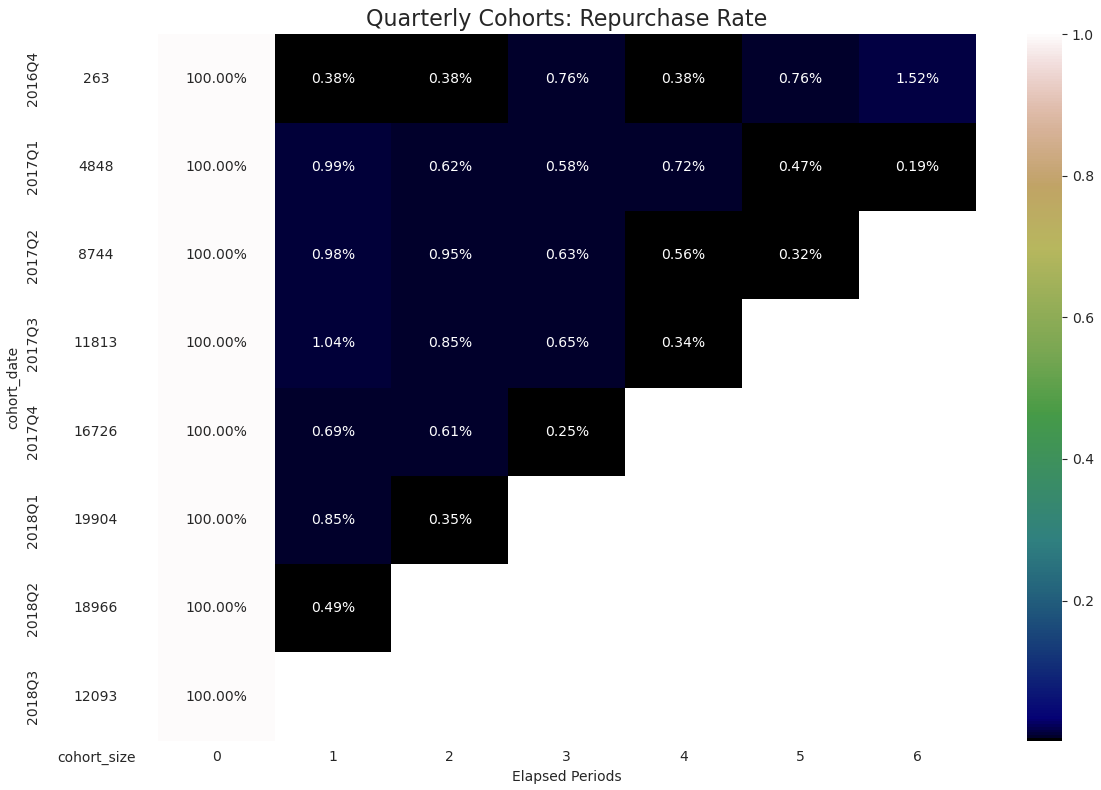

In [16]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8),
        sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # Retention matrix
    sns.heatmap(retention_matrix, mask = retention_matrix.isnull(),
        annot=True, fmt='.2%', cmap='gist_earth', ax=ax[1])
    ax[1].set_title('Quarterly Cohorts: Repurchase Rate', fontsize=16)
    ax[1].set(xlabel='Elapsed Periods', ylabel='')
    
    # Cohort size
    cohort_size_df = (pd.DataFrame(cohort_size)
        .rename(columns={0: 'cohort_size'}))
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, annot=True, cbar=False,
                fmt='g', cmap=white_cmap, ax=ax[0])
    
    fig.tight_layout()

Let's check for monthly and annual cohorts for further inspection. We'll make the previous steps a function for an easier procedure.

In [17]:
def cohort_viz(granularity: ['Y', 'Q', 'M']):

    df_cohort_g = df.loc[:, ['customer_unique_id', 'order_purchase_timestamp']]

    df_cohort_g['cohort_date'] = (
        df_cohort_g.groupby('customer_unique_id')
        ['order_purchase_timestamp']
        .transform('min').dt.to_period(granularity)
    )

    df_cohort_g['granular_period'] = (
        df_cohort_g['order_purchase_timestamp']
            .dt.to_period(granularity))

    df_cohort_g = df_cohort_g.groupby(['cohort_date',
        'granular_period'], as_index=False).agg(
        n_customers = ('customer_unique_id', 'nunique'))

    df_cohort_g['elapsed_period'] = (
        df_cohort_g['granular_period'] - 
        df_cohort_g['cohort_date']).apply(lambda x: x.n)

    cohort_table_g = df_cohort_g.pivot(
          index = 'cohort_date',
        columns = 'elapsed_period',
         values = 'n_customers'
    )

    cohort_size_g = cohort_table_g.iloc[:, 0]
    retention_matrix_g = cohort_table_g.divide(cohort_size_g, axis=0)

    # Set the figure size and title
    fig_size = {'Y': (8, 6), 'Q': (12, 8), 'M': (20, 12)}
    title    = {'Y': 'Annual', 'Q': 'Quarterly', 'M': 'Monthly'}

    with sns.axes_style('white'):
        fig, ax = plt.subplots(1, 2, figsize=fig_size[granularity],
            sharey=True, gridspec_kw={'width_ratios': [1, 11]})

        # Retention matrix
        sns.heatmap(retention_matrix_g, mask = retention_matrix_g.isnull(),
            annot=True, fmt='.2%', cmap='gist_earth', ax=ax[1])
        ax[1].set_title(f'{title[granularity]} Cohorts: Repurchase Rate', fontsize=16)
        ax[1].set(xlabel='Elapsed Periods', ylabel='')

        # Cohort size
        cohort_size_df = (pd.DataFrame(cohort_size_g)
            .rename(columns={0: 'cohort_size'}))
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(cohort_size_df, annot=True, cbar=False,
                    fmt='g', cmap=white_cmap, ax=ax[0])

        fig.tight_layout()

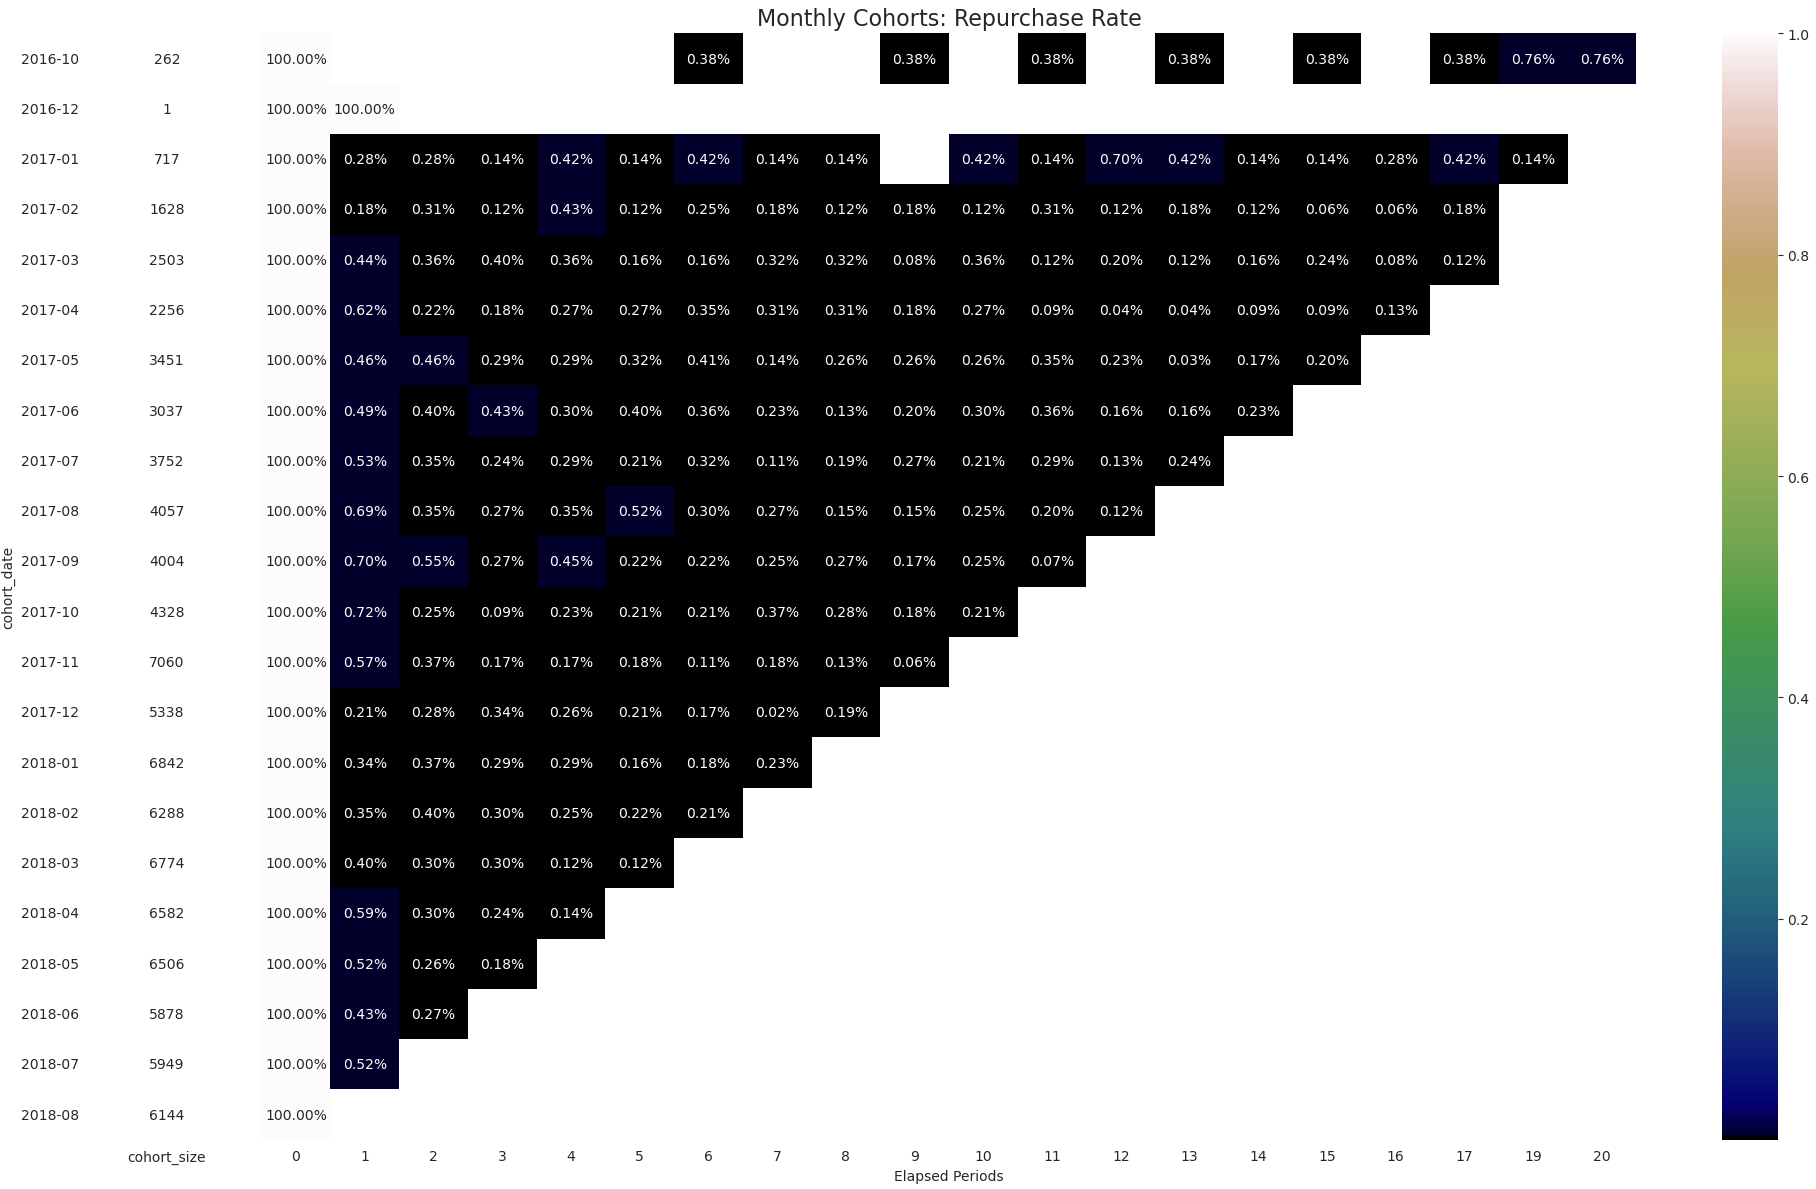

In [18]:
cohort_viz('M')

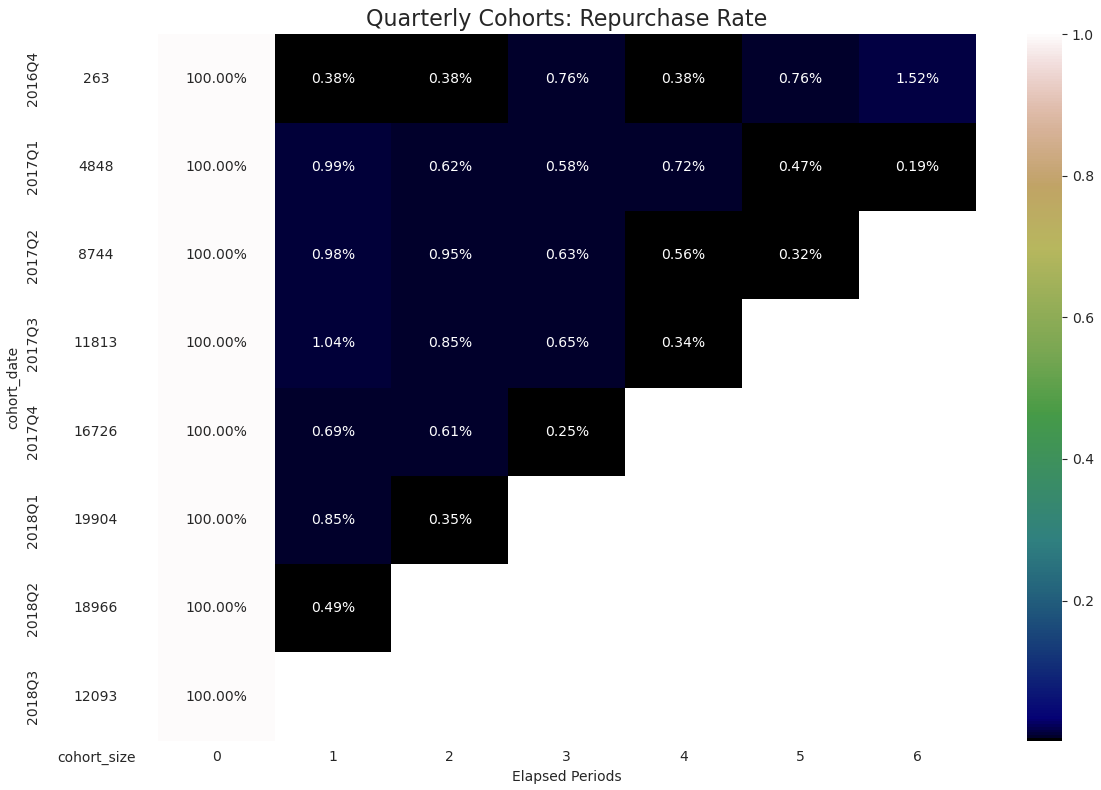

In [19]:
cohort_viz('Q')

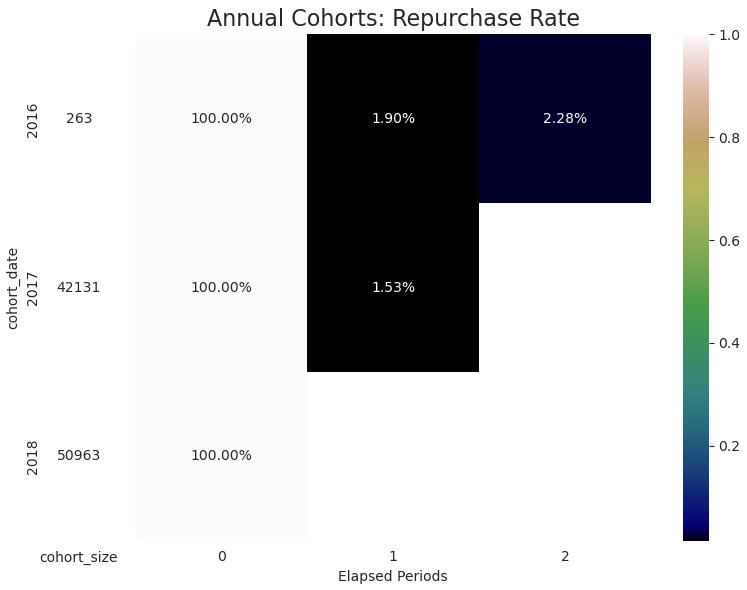

In [20]:
cohort_viz('Y')

As we can see from the heatmaps above, that both monthly and quarterly repurchase rate only reaches less than 1% at best. **Most customers are only buying at olist less than once a year**. This makes olist having a business mode of ***Acquisition Mode***.

Now that we know the business mode, we can determine our focus on **how to amp up customer acquisition**. This will be our focus on the upcoming analysis and dashboard.

## Data Analysis: Trends in Transactions

### Trends by Month

In [21]:
## Total unique customer by month
df_per_month = df.groupby(
    df['order_purchase_timestamp'].dt.to_period('M')).agg(
        num_customers = ('customer_unique_id', 'count'),
        total_sales   = ('total_sales', 'sum')
)

## Reindex to fill missing values of '2016-11' 
## for easier calculation of YoY sales growth.
idx_period = pd.period_range(start='2016-10-01', end='2018-08-01', freq='M')
df_per_month = df_per_month.reindex(idx_period, fill_value=0)

## Add total sales by previous year
df_per_month['total_sales_prev_year'] = (
    df_per_month['total_sales'].shift(periods=12))

df_per_month['CLV'] = df_per_month['total_sales'] / df_per_month['num_customers']

df_per_month['YoY_growth'] = (
    (df_per_month['total_sales'] -
     df_per_month['total_sales_prev_year']
) / df_per_month['total_sales_prev_year']) * 100

# df_per_month.loc['YoY_growth', :-8]

In [22]:
df_per_month

num_customers  total_sales  total_sales_prev_year         CLV  \
2016-10            334     48314.12                    NaN  144.653054   
2016-11              0         0.00                    NaN         NaN   
2016-12              1        19.62                    NaN   19.620000   
2017-01            981    138323.99                    NaN  141.003048   
2017-02           1973    286678.44                    NaN  145.300781   
2017-03           3098    442061.00                    NaN  142.692382   
2017-04           2715    414527.46                    NaN  152.680464   
2017-05           4308    614885.90                    NaN  142.731175   
2017-06           3727    518076.28                    NaN  139.006246   
2017-07           4771    610664.84                    NaN  127.995146   
2017-08           5107    680858.92                    NaN  133.318762   
2017-09           5040    746898.44                    NaN  148.194135   
2017-10           5497    789406.96               48314.12  143.606869   
2017-11           8891   1205033.35                   0.00  135.534063   
2017-12           6469    877503.67                  19.62  135.647499   
2018-01           8418   1128224.39              138323.99  134.025230   
2018-02           7864   1016511.44              286678.44  129.261373   
2018-03           8384   1172957.65              442061.00  139.904300   
2018-04           8123   1174143.49              414527.46  144.545548   
2018-05           8113   1171614.43              614885.90  144.411984   
2018-06           7327   1064996.68              518076.28  145.352352   
2018-07           7223   1066593.79              610664.84  147.666315   
2018-08           7356   1020340.91              680858.92  138.708661   

           YoY_growth  
2016-10           NaN  
2016-11           NaN  
2016-12           NaN  
2017-01           NaN  
2017-02           NaN  
2017-03           NaN  
2017-04           NaN  
2017-05           NaN  
2017-06           NaN  
2017-07           NaN  
2017-08           NaN  
2017-09           NaN  
2017-10  1.533905e+03  
2017-11           inf  
2017-12  4.472396e+06  
2018-01  7.156390e+02  
2018-02  2.545825e+02  
2018-03  1.653384e+02  
2018-04  1.832487e+02  
2018-05  9.054176e+01  
2018-06  1.055675e+02  
2018-07  7.466108e+01  
2018-08  4.986084e+01

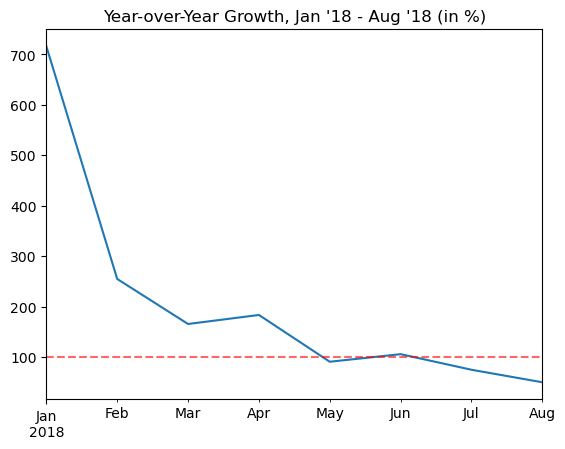

In [23]:
## Year-over-Year Growth 

df_per_month['YoY_growth'][-8:].plot(title=
    "Year-over-Year Growth, Jan '18 - Aug '18 (in %)")
plt.axhline(y=100, color='r', linestyle='--', alpha=0.6)

In [24]:
df_per_month['num_customers'].mean()

5031.304347826087

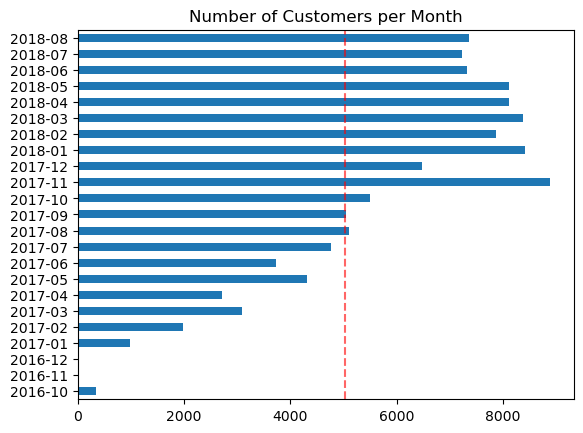

In [25]:
df_per_month['num_customers'].plot.barh(
    title='Number of Customers per Month')
plt.axvline(x=df_per_month['num_customers'].mean(),
            color='r', linestyle='--', alpha=0.6)

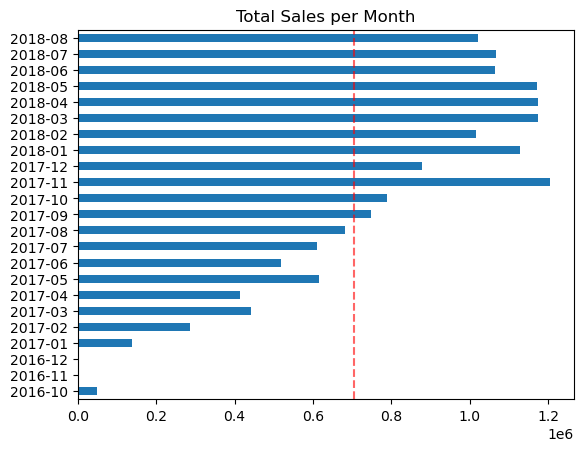

In [26]:
df_per_month['total_sales'].plot.barh(
    title='Total Sales per Month')
plt.axvline(x=df_per_month['total_sales'].mean(),
            color='r', linestyle='--', alpha=0.6)

### Trends by Product Category

In [27]:
df_ctg = df.groupby('product_category_name_english').agg(
    num_customers = ('customer_unique_id', 'count'),
    total_sales   = ('total_sales', 'sum'),
)

df_ctg['avg_purchase_price'] = df_ctg['total_sales'] / df_ctg['num_customers']

In [28]:
df_ctg.sort_values('total_sales', ascending=False)

num_customers  total_sales  avg_purchase_price
product_category_name_english                                                
health_beauty                           9813   1461206.29          148.905155
watches_gifts                           6077   1316696.84          216.668889
bed_bath_table                         11814   1309729.85          110.862523
sports_leisure                          8791   1166307.34          132.670611
computers_accessories                   7963   1077483.63          135.311268
...                                      ...          ...                 ...
pc_gamer                                   9      1575.17          175.018889
home_comfort_2                            31      1194.44           38.530323
cds_dvds_musicals                         14       954.99           68.213571
fashion_childrens_clothes                  7       598.67           85.524286
security_and_services                      2       324.51          162.255000

[74 rows x 3 columns]

In [29]:
df_ctg['total_sales'].mean()

218765.34824324324

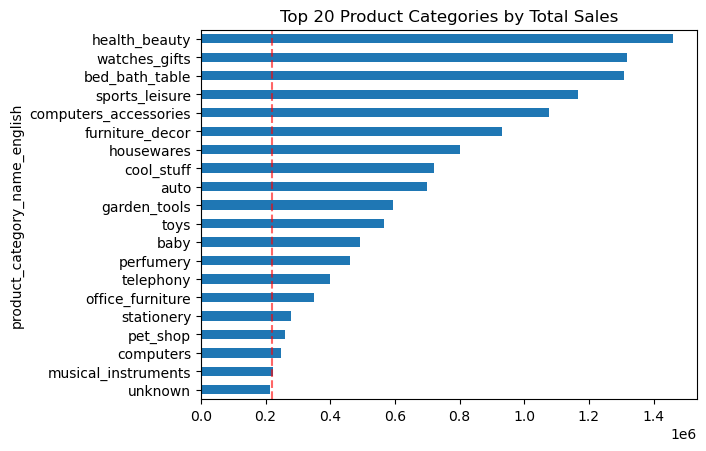

In [30]:
df_ctg.sort_values('total_sales', ascending=False)['total_sales'][:20].plot.barh(
    title='Top 20 Product Categories by Total Sales').invert_yaxis()
plt.axvline(x=df_ctg['total_sales'].mean(),
            color='r', linestyle='--', alpha=0.6)

In [31]:
df_ctg['num_customers'].mean()

1563.7837837837837

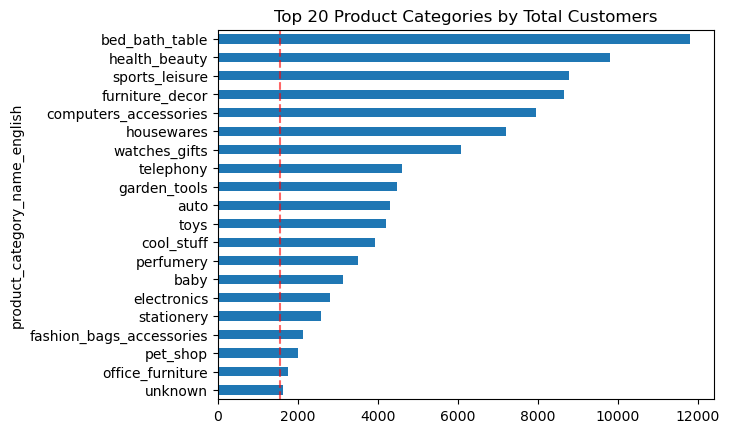

In [32]:
df_ctg.sort_values('num_customers', ascending=False)['num_customers'][:20].plot.barh(
    title='Top 20 Product Categories by Total Customers').invert_yaxis()
plt.axvline(x=df_ctg['num_customers'].mean(),
            color='r', linestyle='--', alpha=0.6)

In [33]:
df_ctg['avg_purchase_price'].mean()

167.07389810535142

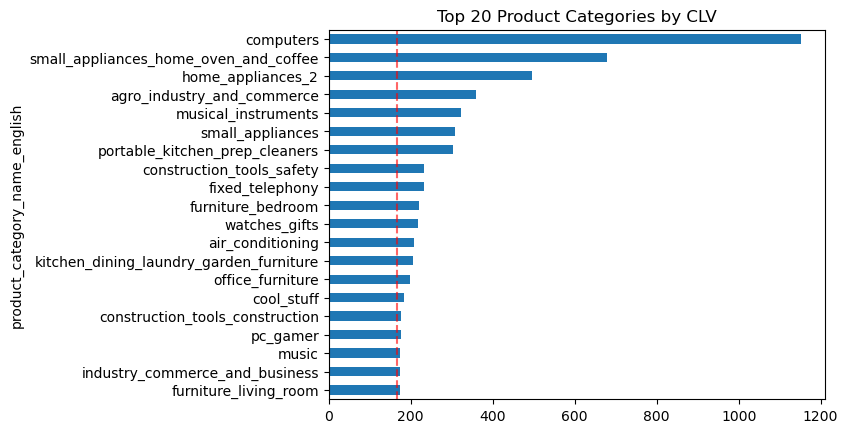

In [34]:
df_ctg.sort_values(
    'avg_purchase_price', ascending=False
)['avg_purchase_price'][:20].plot.barh(
    title='Top 20 Product Categories by CLV').invert_yaxis()
plt.axvline(x=df_ctg['avg_purchase_price'].mean(),
            color='r', linestyle='--', alpha=0.6)

#### Insights: Product Category by Sales

From the graphs above, we found that:

- 18 out of 20 product categories are included in both top 20 by total sales *and* total customers, with
    - `computers` and `musical_instruments` in only Total Sales, and 
    - `fashion_bags_accessories` and `electronics` in only Total Customers.

* The third graph of average purchase size shows the top 20 high-converting product categories, which have a different list than the first two graphs. From the product list, we can see that it includes big, functional, or luxury products such as:

    * `computers`, `small_appliances_home_oven_and_coffee`, and `furniture_bedroom`, or
    * `musical_instruments`, `air_conditioning`, and `watches_gifts`

* The majority of top 20 product categories reaches the average respective metrics of total sales (218,765.35 BRL), total customers (1563.78 customers), and CLV (167.074 BRL). 

* By optimizing the sales in these product categories, we can increase the respective metrics. We suggest several recommendations:

    * We can focus on the top 7 on both total sales and total customers seeing that they generate the highest conversion compared to the other categories, OR

    * By comparing the first two visuals along with visuals of CLV, we have potentials in high-converting product categories that generates either high total sales and/or high total customers:`computers`, `watches_gifts`, `cool_stuff`, `musical_instruments`. We can spend a good amount of marketing budget upon these categories.

Let's dissect the product category per month, along with Year-over-Year sales growth by creating two types of visuals: a **heatmap**, just like the cohort analysis, and a **line graph**, just like the previous YoY sales growth.

### Orders by Product Category per Month

In [35]:
df_viz = df.loc[:, [
    'order_id', 'customer_unique_id', 'customer_city',
    'customer_state', 'customer_zip_code_prefix', 
    'order_purchase_timestamp', 'payment_type', 
    'review_score', 'product_category_name_english', 'total_sales'
]]  

In [36]:
df_viz

order_id                customer_unique_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  7c396fd4830fd04220f754e42b4e5bff   
1       e481f51cbdc54678b7cc49136f2d6af7  7c396fd4830fd04220f754e42b4e5bff   
2       e481f51cbdc54678b7cc49136f2d6af7  7c396fd4830fd04220f754e42b4e5bff   
3       53cdb2fc8bc7dce0b6741e2150273451  af07308b275d755c9edb36a90c618231   
4       47770eb9100c2d0c44946d9cf07ec65d  3a653a41f6f9fc3d2a113cf8398680e8   
...                                  ...                               ...   
115715  63943bddc261676b46f01ca7ac2f7bd8  da62f9e57a76d978d02ab5362c509660   
115716  83c1379a015df1e13d02aae0204711ab  737520a9aad80b3fbbdad19b66b37b30   
115717  11c177c8e97725db2631073c19f07b62  5097a5312c8b157bb7be58ae360ef43c   
115718  11c177c8e97725db2631073c19f07b62  5097a5312c8b157bb7be58ae360ef43c   
115719  66dea50a8b16d9b4dee7af250b4be1a5  60350aa974b26ff12caad89e55993bd6   

       customer_city customer_state  customer_zip_code_prefix  \
0          sao paulo             SP                      3149   
1          sao paulo             SP                      3149   
2          sao paulo             SP                      3149   
3          barreiras             BA                     47813   
4         vianopolis             GO                     75265   
...              ...            ...                       ...   
115715  praia grande             SP                     11722   
115716   nova vicosa             BA                     45920   
115717       japuiba             RJ                     28685   
115718       japuiba             RJ                     28685   
115719          lapa             PR                     83750   

       order_purchase_timestamp payment_type  review_score  \
0           2017-10-02 10:56:00  credit_card           4.0   
1           2017-10-02 10:56:00      voucher           4.0   
2           2017-10-02 10:56:00      voucher           4.0   
3           2018-07-24 20:41:00       boleto           4.0   
4           2018-08-08 08:38:00  credit_card           5.0   
...                         ...          ...           ...   
115715      2018-02-06 12:58:00  credit_card           4.0   
115716      2017-08-27 14:46:00  credit_card           5.0   
115717      2018-01-08 21:28:00  credit_card           2.0   
115718      2018-01-08 21:28:00  credit_card           2.0   
115719      2018-03-08 20:57:00   debit_card           5.0   

       product_category_name_english  total_sales  
0                         housewares        38.71  
1                         housewares        38.71  
2                         housewares        38.71  
3                          perfumery       141.46  
4                               auto       179.12  
...                              ...          ...  
115715                          baby       195.00  
115716             home_appliances_2       271.01  
115717         computers_accessories       220.58  
115718         computers_accessories       220.58  
115719                 health_beauty        86.86  

[115720 rows x 10 columns]

In [37]:
order_by_product_ctg_per_month = pd.DataFrame(df_viz.groupby([
    df_viz['order_purchase_timestamp'].dt.to_period('M'),
    df_viz['product_category_name_english']
])['customer_unique_id'].count())

In [38]:
order_by_product_ctg_per_month

customer_unique_id
order_purchase_timestamp product_category_name_english                    
2016-10                  air_conditioning                                8
                         audio                                           2
                         auto                                            8
                         baby                                           11
                         bed_bath_table                                  8
...                                                                    ...
2018-08                  stationery                                    171
                         telephony                                     283
                         toys                                          165
                         unknown                                        31
                         watches_gifts                                 422

[1272 rows x 1 columns]

In [39]:
## Some categories are not touched within a certain month,
## therefore making the following category unlisted.

## Here we'll create the same number of product categories
## so that we show the unlisted categories, with
## number of unique customers displayed as 0

## idx_period_M is added to the list for adding '2016-11',
## the period wuth no sales. This way we can calculate YoY easier.
idx_period_M = pd.period_range(
    start='2016-10-01', end='2018-08-01', freq='M')

new_index = pd.MultiIndex.from_product([idx_period_M, 
    order_by_product_ctg_per_month.index.levels[1]],
    names = order_by_product_ctg_per_month.index.names
)

order_by_product_ctg_per_month = (
    order_by_product_ctg_per_month.reindex(
        new_index, fill_value=0)
)

In [40]:
order_by_product_ctg_per_month

customer_unique_id
order_purchase_timestamp product_category_name_english                    
2016-10                  agro_industry_and_commerce                      0
                         air_conditioning                                8
                         art                                             0
                         arts_and_craftmanship                           0
                         audio                                           2
...                                                                    ...
2018-08                  tablets_printing_image                          0
                         telephony                                     283
                         toys                                          165
                         unknown                                        31
                         watches_gifts                                 422

[1702 rows x 1 columns]

In [41]:
total_order_by_product_ctg = pd.DataFrame(
    df_viz['product_category_name_english'].value_counts()
).rename(columns={'count': 'Total Order'})

order_by_product_ctg_per_month_pivot = (
    order_by_product_ctg_per_month.reset_index().pivot(
        index='order_purchase_timestamp',
        columns='product_category_name_english',
        values='customer_unique_id').T
)

In [42]:
total_order_by_product_ctg

Total Order
product_category_name_english              
bed_bath_table                        11814
health_beauty                          9813
sports_leisure                         8791
furniture_decor                        8643
computers_accessories                  7963
...                                     ...
portable_kitchen_prep_cleaners           14
cds_dvds_musicals                        14
pc_gamer                                  9
fashion_childrens_clothes                 7
security_and_services                     2

[74 rows x 1 columns]

In [43]:
order_by_product_ctg_per_month_pivot

order_purchase_timestamp       2016-10  2016-11  2016-12  2017-01  2017-02  \
product_category_name_english                                                
agro_industry_and_commerce           0        0        0        3        9   
air_conditioning                     8        0        0        4       12   
art                                  0        0        0        0        0   
arts_and_craftmanship                0        0        0        0        0   
audio                                2        0        0        0        7   
...                                ...      ...      ...      ...      ...   
tablets_printing_image               0        0        0        0        8   
telephony                            8        0        0       22      110   
toys                                24        0        0       42       67   
unknown                              2        0        0       12       57   
watches_gifts                        4        0        0       11       35   

order_purchase_timestamp       2017-03  2017-04  2017-05  2017-06  2017-07  \
product_category_name_english                                                
agro_industry_and_commerce           2        0        4        1        1   
air_conditioning                    18       15        7       11        5   
art                                  6        1        6        6        3   
arts_and_craftmanship                0        0        1        0        1   
audio                               14       12       17       11        6   
...                                ...      ...      ...      ...      ...   
tablets_printing_image               5       12        7        8        2   
telephony                          170      146      219      167      159   
toys                               103      116      201      157      216   
unknown                             64       76       98       60       72   
watches_gifts                       80      104      136      125      171   

order_purchase_timestamp       2017-08  2017-09  2017-10  2017-11  2017-12  \
product_category_name_english                                                
agro_industry_and_commerce           4        4        5       19       11   
air_conditioning                    16        7       14       19        3   
art                                  4        3        3        2        4   
arts_and_craftmanship                0        0        0        0        0   
audio                                9       11       32       38       18   
...                                ...      ...      ...      ...      ...   
tablets_printing_image               7        3        1        6        6   
telephony                          135      174      258      383      273   
toys                               187      305      302      512      443   
unknown                             79       81       69      129      144   
watches_gifts                      216      277      323      472      362   

order_purchase_timestamp       2018-01  2018-02  2018-03  2018-04  2018-05  \
product_category_name_english                                                
agro_industry_and_commerce          18       48       41       12        8   
air_conditioning                    29       12       24       23       14   
art                                 19       13        7       26       35   
arts_and_craftmanship                0        0        0        1        1   
audio                               27       15       34       32       21   
...                                ...      ...      ...      ...      ...   
tablets_printing_image               3       13        3        1        1   
telephony                          384      368      349      301      253   
toys                               165      150      242      204      224   
unknown                            203      123      137       77       52   
watches_gifts      

In [44]:
## Sort pivot table with index from `total_order_by_product_ctg`
order_by_product_ctg_per_month_pivot = (
    order_by_product_ctg_per_month_pivot.reindex(
        total_order_by_product_ctg.index))

In [45]:
order_by_product_ctg_per_month_pivot

order_purchase_timestamp        2016-10  2016-11  2016-12  2017-01  2017-02  \
product_category_name_english                                                 
bed_bath_table                        8        0        0       49      172   
health_beauty                        42        0        0       88      171   
sports_leisure                       17        0        0       86      160   
furniture_decor                      77        0        0      202      273   
computers_accessories                15        0        0       31      100   
...                                 ...      ...      ...      ...      ...   
portable_kitchen_prep_cleaners        0        0        0        0        0   
cds_dvds_musicals                     0        0        0        0        0   
pc_gamer                              0        0        0        0        0   
fashion_childrens_clothes             0        0        0        0        0   
security_and_services                 0        0        0        1        0   

order_purchase_timestamp        2017-03  2017-04  2017-05  2017-06  2017-07  \
product_category_name_english                                                 
bed_bath_table                      313      309      421      422      628   
health_beauty                       212      185      298      270      321   
sports_leisure                      206      209      317      283      410   
furniture_decor                     334      201      319      238      340   
computers_accessories               172      136      325      266      344   
...                                 ...      ...      ...      ...      ...   
portable_kitchen_prep_cleaners        0        0        0        0        0   
cds_dvds_musicals                     0        0        0        0        5   
pc_gamer                              0        3        1        1        0   
fashion_childrens_clothes             0        0        1        1        0   
security_and_services                 0        0        0        0        0   

order_purchase_timestamp        2017-08  2017-09  2017-10  2017-11  2017-12  \
product_category_name_english                                                 
bed_bath_table                      584      569      608     1022      578   
health_beauty                       366      402      372      594      474   
sports_leisure                      432      468      491      620      507   
furniture_decor                     458      358      388      805      406   
computers_accessories               367      263      320      534      295   
...                                 ...      ...      ...      ...      ...   
portable_kitchen_prep_cleaners        0        0        0        0        0   
cds_dvds_musicals                     3        0        1        3        1   
pc_gamer                              0        0        0        0        0   
fashion_childrens_clothes             0        1        1        0        0   
security_and_services                 0        1        0        0        0   

order_purchase_timestamp        2018-01  2018-02  2018-03  2018-04  2018-05  \
product_category_name_english                                                 
bed_bath_table                      908      736      822      766      776   
health_beauty                       638      675      679      695      784   
sports_leisure                      664      659      759      600      504   
furniture_decor                     638      432      620      623      609   
computers_accessories               721     1010      768      534      486   
...                                 ...      ...      ...      ...      ...   
portable_kitchen_prep_cleaners        0        0        0        0        2   
cds_dvds_musicals                     0        0        0        1        0   
pc_gamer                              0        1        0        0        0   
fashion_childrens_clothes             0        

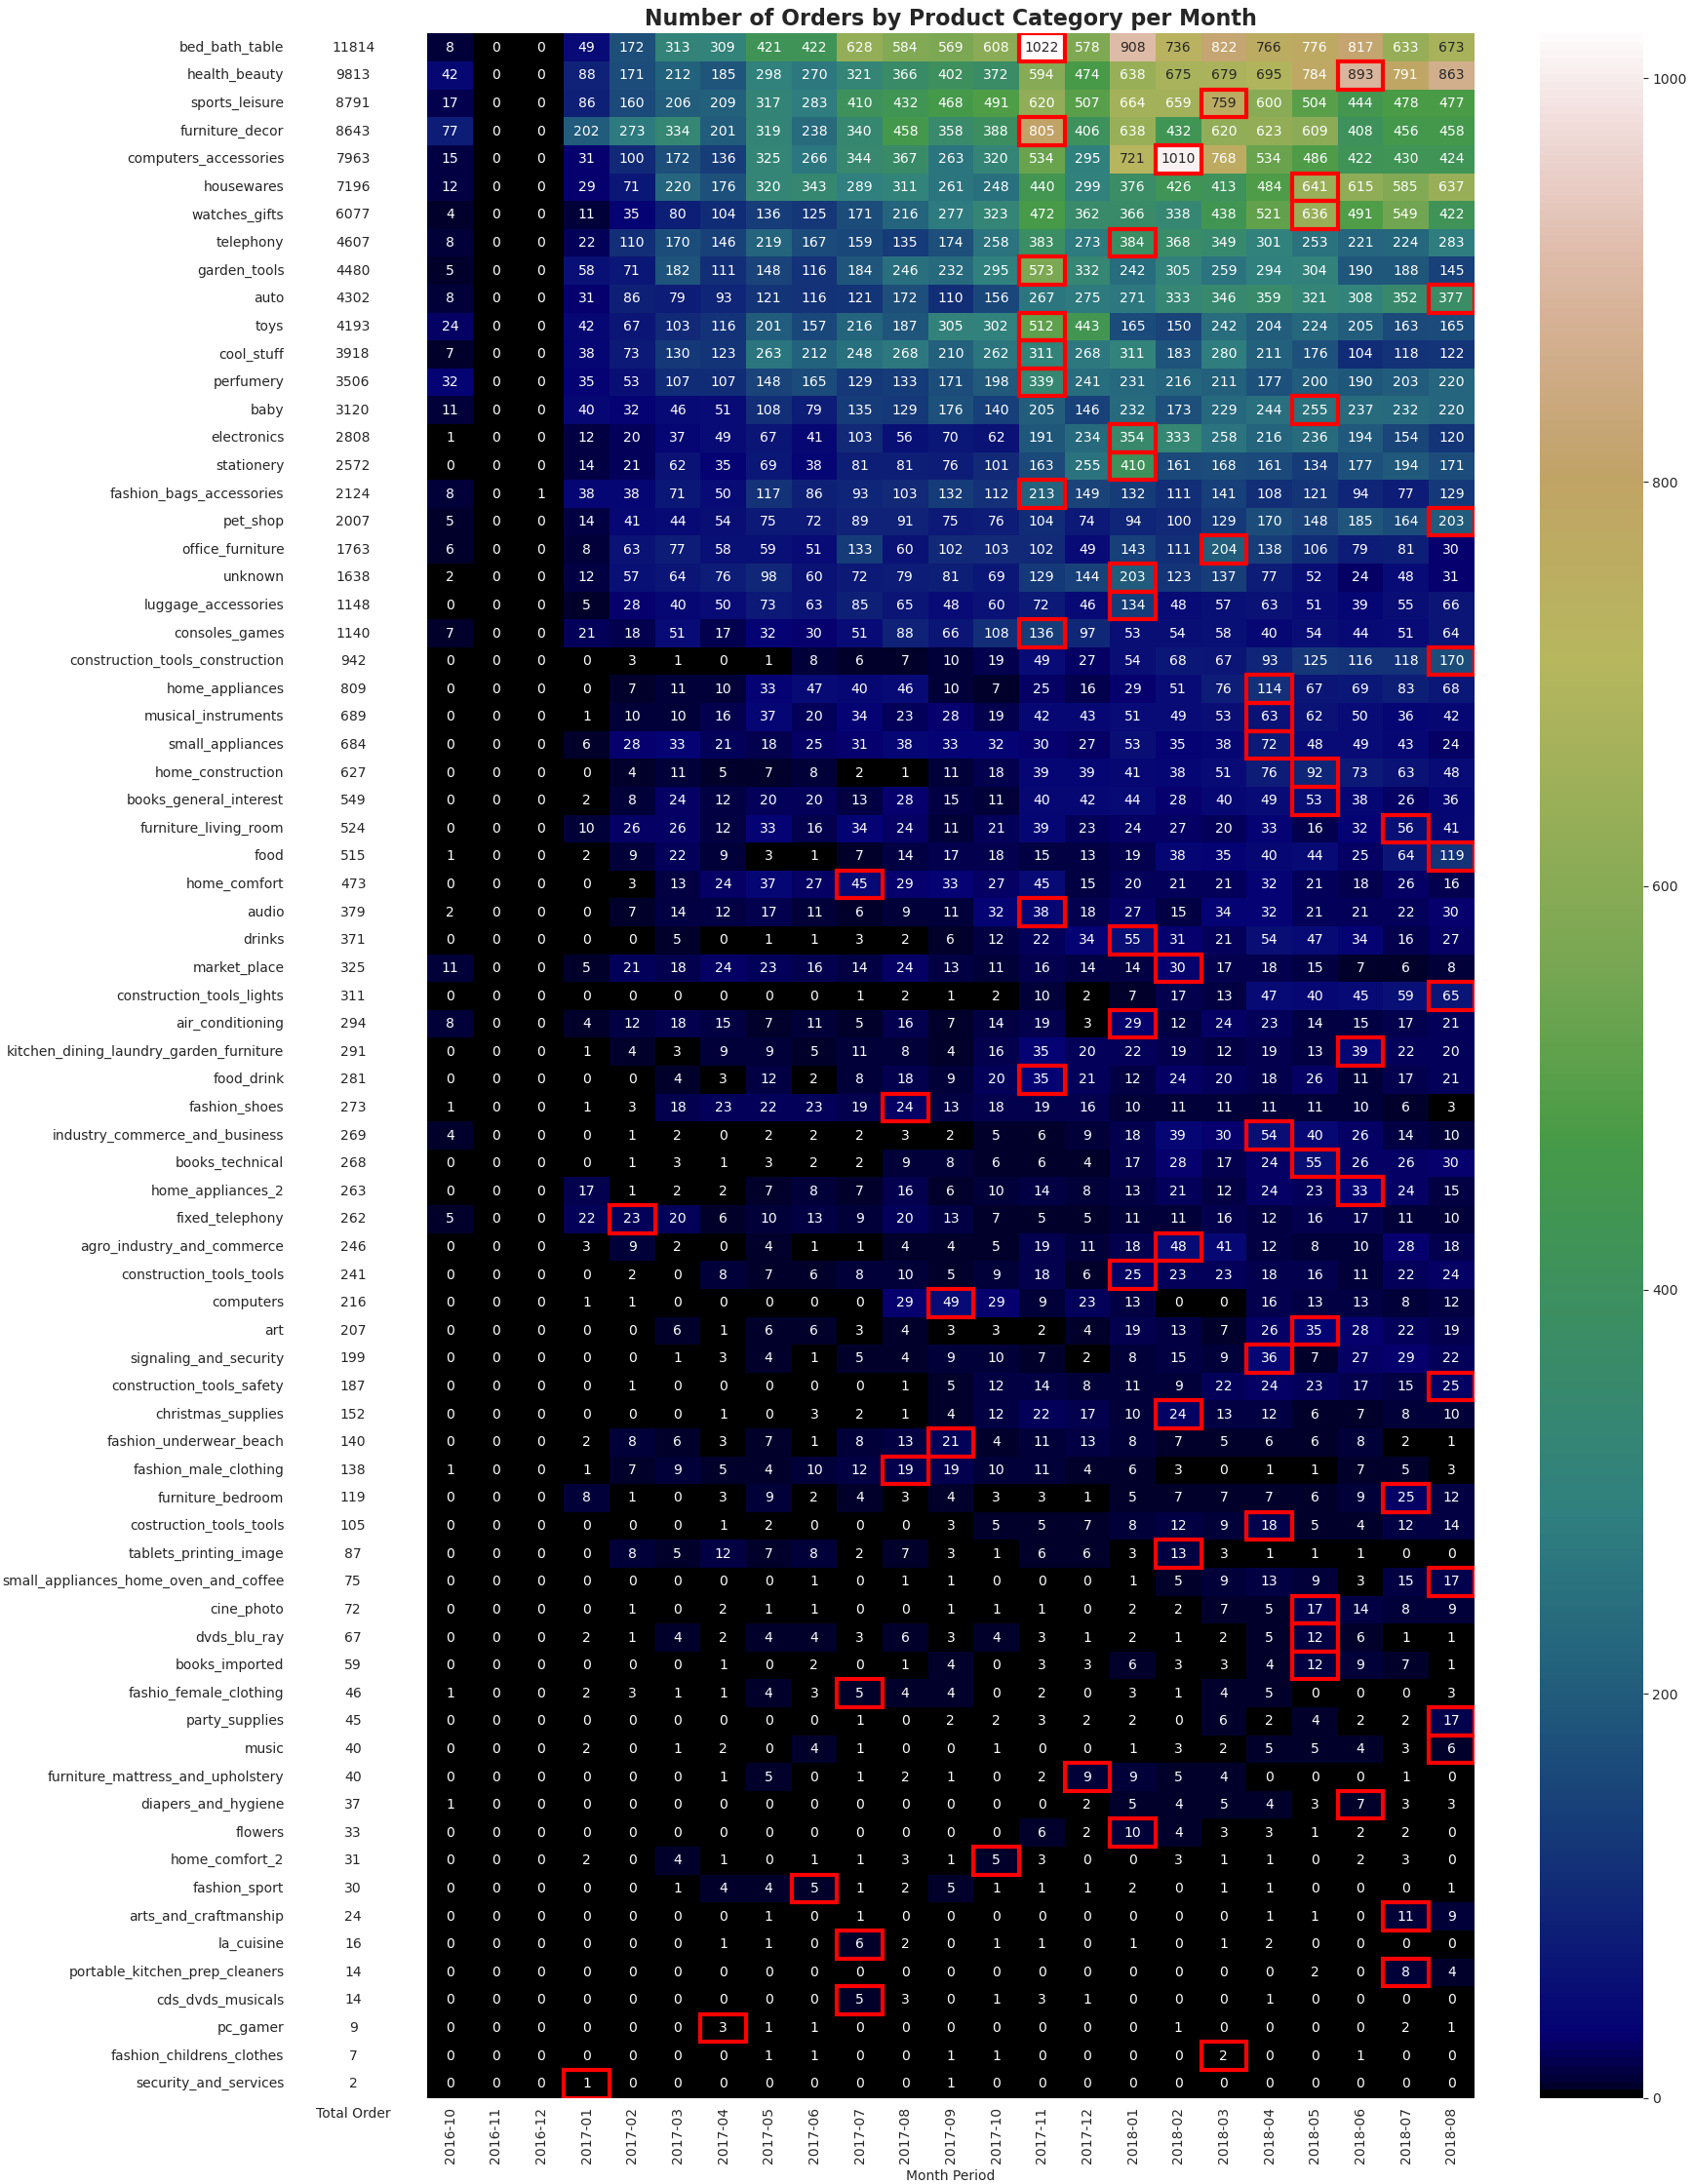

In [46]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(18, 22.5),
        sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # Product Category per Month
    sns.heatmap(order_by_product_ctg_per_month_pivot,
        annot=True, fmt='g', cmap='gist_earth', ax=ax[1])
    ax[1].set_title(
        'Number of Orders by Product Category per Month', 
        fontsize=16, fontweight='bold')
    ax[1].set(xlabel='Month Period', ylabel='')
    
    # Highlighting highest number of order per product category
    row_max = order_by_product_ctg_per_month_pivot.idxmax(axis=1)
    
    for row, index in enumerate(
        order_by_product_ctg_per_month_pivot.index):
        
        position = (
            order_by_product_ctg_per_month_pivot
                .columns.get_loc(row_max[index]))
        ax[1].add_patch(Rectangle((position, row),
            1, 1, fill=False, edgecolor='red', lw=3))
       
    white_cmap = mcolors.ListedColormap(['white'])
        
    # Total Order by Product Category
    sns.heatmap(total_order_by_product_ctg, 
        annot=True, cbar=False, fmt='g', 
        cmap=white_cmap, ax=ax[0])
        
    fig.tight_layout()

We'll visualize another heatmap for total profit as well.

In [47]:
#### (1) Sales by Product Category per Month

sales_by_product_ctg_per_month = pd.DataFrame(df_viz.groupby([
    df_viz['order_purchase_timestamp'].dt.to_period('M'),
    df_viz['product_category_name_english']
])['total_sales'].sum())

## Some categories are not touched within a certain month,
## therefore making the following category unlisted.

## Here we'll create the same number of product categories
## so that we show the unlisted categories, with
## number of unique customers displayed as 0

## idx_period_M is added to the list for adding '2016-11'
idx_period_M = pd.period_range(
    start='2016-10-01', end='2018-08-01', freq='M')

new_index = pd.MultiIndex.from_product([idx_period_M, 
    sales_by_product_ctg_per_month.index.levels[1]],
    names = sales_by_product_ctg_per_month.index.names
)

sales_by_product_ctg_per_month = (
    sales_by_product_ctg_per_month.reindex(
        new_index, fill_value=0)
)

sales_by_product_ctg_per_month_pivot = (
    sales_by_product_ctg_per_month.reset_index().pivot(
        index='order_purchase_timestamp',
        columns='product_category_name_english',
        values='total_sales').T
)

new_index = pd.MultiIndex.from_product([idx_period_M, 
    order_by_product_ctg_per_month.index.levels[1]],
    names = order_by_product_ctg_per_month.index.names
)

#### (2) Total Sales by Product Category

total_sales_by_product_ctg = pd.DataFrame(df_viz.groupby(
    df_viz['product_category_name_english'])['total_sales'].sum()
    .sort_values(ascending=False)
).rename(columns={'total_sales': 'Total Sales'})

#### (3) Reindex (2) with index of (1)

sales_by_product_ctg_per_month_pivot = (
    sales_by_product_ctg_per_month_pivot.reindex(
        total_sales_by_product_ctg.index))

In [48]:
total_sales_by_product_ctg

Total Sales
product_category_name_english             
health_beauty                   1461206.29
watches_gifts                   1316696.84
bed_bath_table                  1309729.85
sports_leisure                  1166307.34
computers_accessories           1077483.63
...                                    ...
pc_gamer                           1575.17
home_comfort_2                     1194.44
cds_dvds_musicals                   954.99
fashion_childrens_clothes           598.67
security_and_services               324.51

[74 rows x 1 columns]

In [49]:
sales_by_product_ctg_per_month_pivot

order_purchase_timestamp       2016-10  2016-11  2016-12   2017-01   2017-02  \
product_category_name_english                                                  
health_beauty                  4328.71      0.0      0.0  17038.97  29107.58   
watches_gifts                  2793.71      0.0      0.0   8310.83  11632.12   
bed_bath_table                  606.58      0.0      0.0   4936.30  20570.57   
sports_leisure                 2490.76      0.0      0.0  12032.23  19632.25   
computers_accessories          1081.32      0.0      0.0   4377.60  13014.71   
...                                ...      ...      ...       ...       ...   
pc_gamer                          0.00      0.0      0.0      0.00      0.00   
home_comfort_2                    0.00      0.0      0.0     95.57      0.00   
cds_dvds_musicals                 0.00      0.0      0.0      0.00      0.00   
fashion_childrens_clothes         0.00      0.0      0.0      0.00      0.00   
security_and_services             0.00      0.0      0.0    209.06      0.00   

order_purchase_timestamp        2017-03   2017-04   2017-05   2017-06  \
product_category_name_english                                           
health_beauty                  30388.04  26136.82  53721.22  37888.32   
watches_gifts                  26288.78  27178.84  41735.99  30971.66   
bed_bath_table                 32870.27  33117.26  44795.68  44482.02   
sports_leisure                 36161.53  27947.85  41257.83  39252.02   
computers_accessories          31343.82  21098.76  52665.12  42034.82   
...                                 ...       ...       ...       ...   
pc_gamer                           0.00    434.80    138.15    156.18   
home_comfort_2                   414.75     23.86      0.00     28.00   
cds_dvds_musicals                  0.00      0.00      0.00      0.00   
fashion_childrens_clothes          0.00      0.00    124.52    118.96   
security_and_services              0.00      0.00      0.00      0.00   

order_purchase_timestamp        2017-07   2017-08   2017-09   2017-10  \
product_category_name_english                                           
health_beauty                  40922.10  57559.45  61065.94  49331.91   
watches_gifts                  37165.67  41047.74  50319.75  74358.58   
bed_bath_table                 80312.79  70747.84  66157.13  62747.93   
sports_leisure                 50229.38  49846.47  59025.89  59924.03   
computers_accessories          47840.18  41788.42  35251.58  49194.23   
...                                 ...       ...       ...       ...   
pc_gamer                           0.00      0.00      0.00      0.00   
home_comfort_2                    28.00     69.91     29.69    140.00   
cds_dvds_musicals                299.38    177.16      0.00     61.11   
fashion_childrens_clothes          0.00      0.00    107.06     54.09   
security_and_services              0.00      0.00    115.45      0.00   

order_purchase_timestamp         2017-11   2017-12    2018-01    2018-02  \
product_category_name_english                                              
health_beauty                   92877.50  73620.50   84150.85   98114.99   
watches_gifts                  106278.30  76826.64   81868.39   69897.78   
bed_bath_table                 110008.38  62447.62   95859.30   77002.15   
sports_leisure                  76188.85  70539.44  103192.44   89611.18   
computers_accessories           83411.61  44165.83   96549.12  121298.36   
...                                  ...       ...        ...        ...   
pc_gamer                            0.00      0.00       0.00     150.03   
home_comfort_2                     80.75      0.00       0.00      84.00   
cds_dvds_musicals                 224.82     74.94       0.00       0.00   
fashion_childrens_clothes           0.00      0.00       0.00       0.00   
security_and_services               0.00      0.00       0.00       0.00   

order_purchase_timestamp         2018-03    2018-04    2018-05    2018

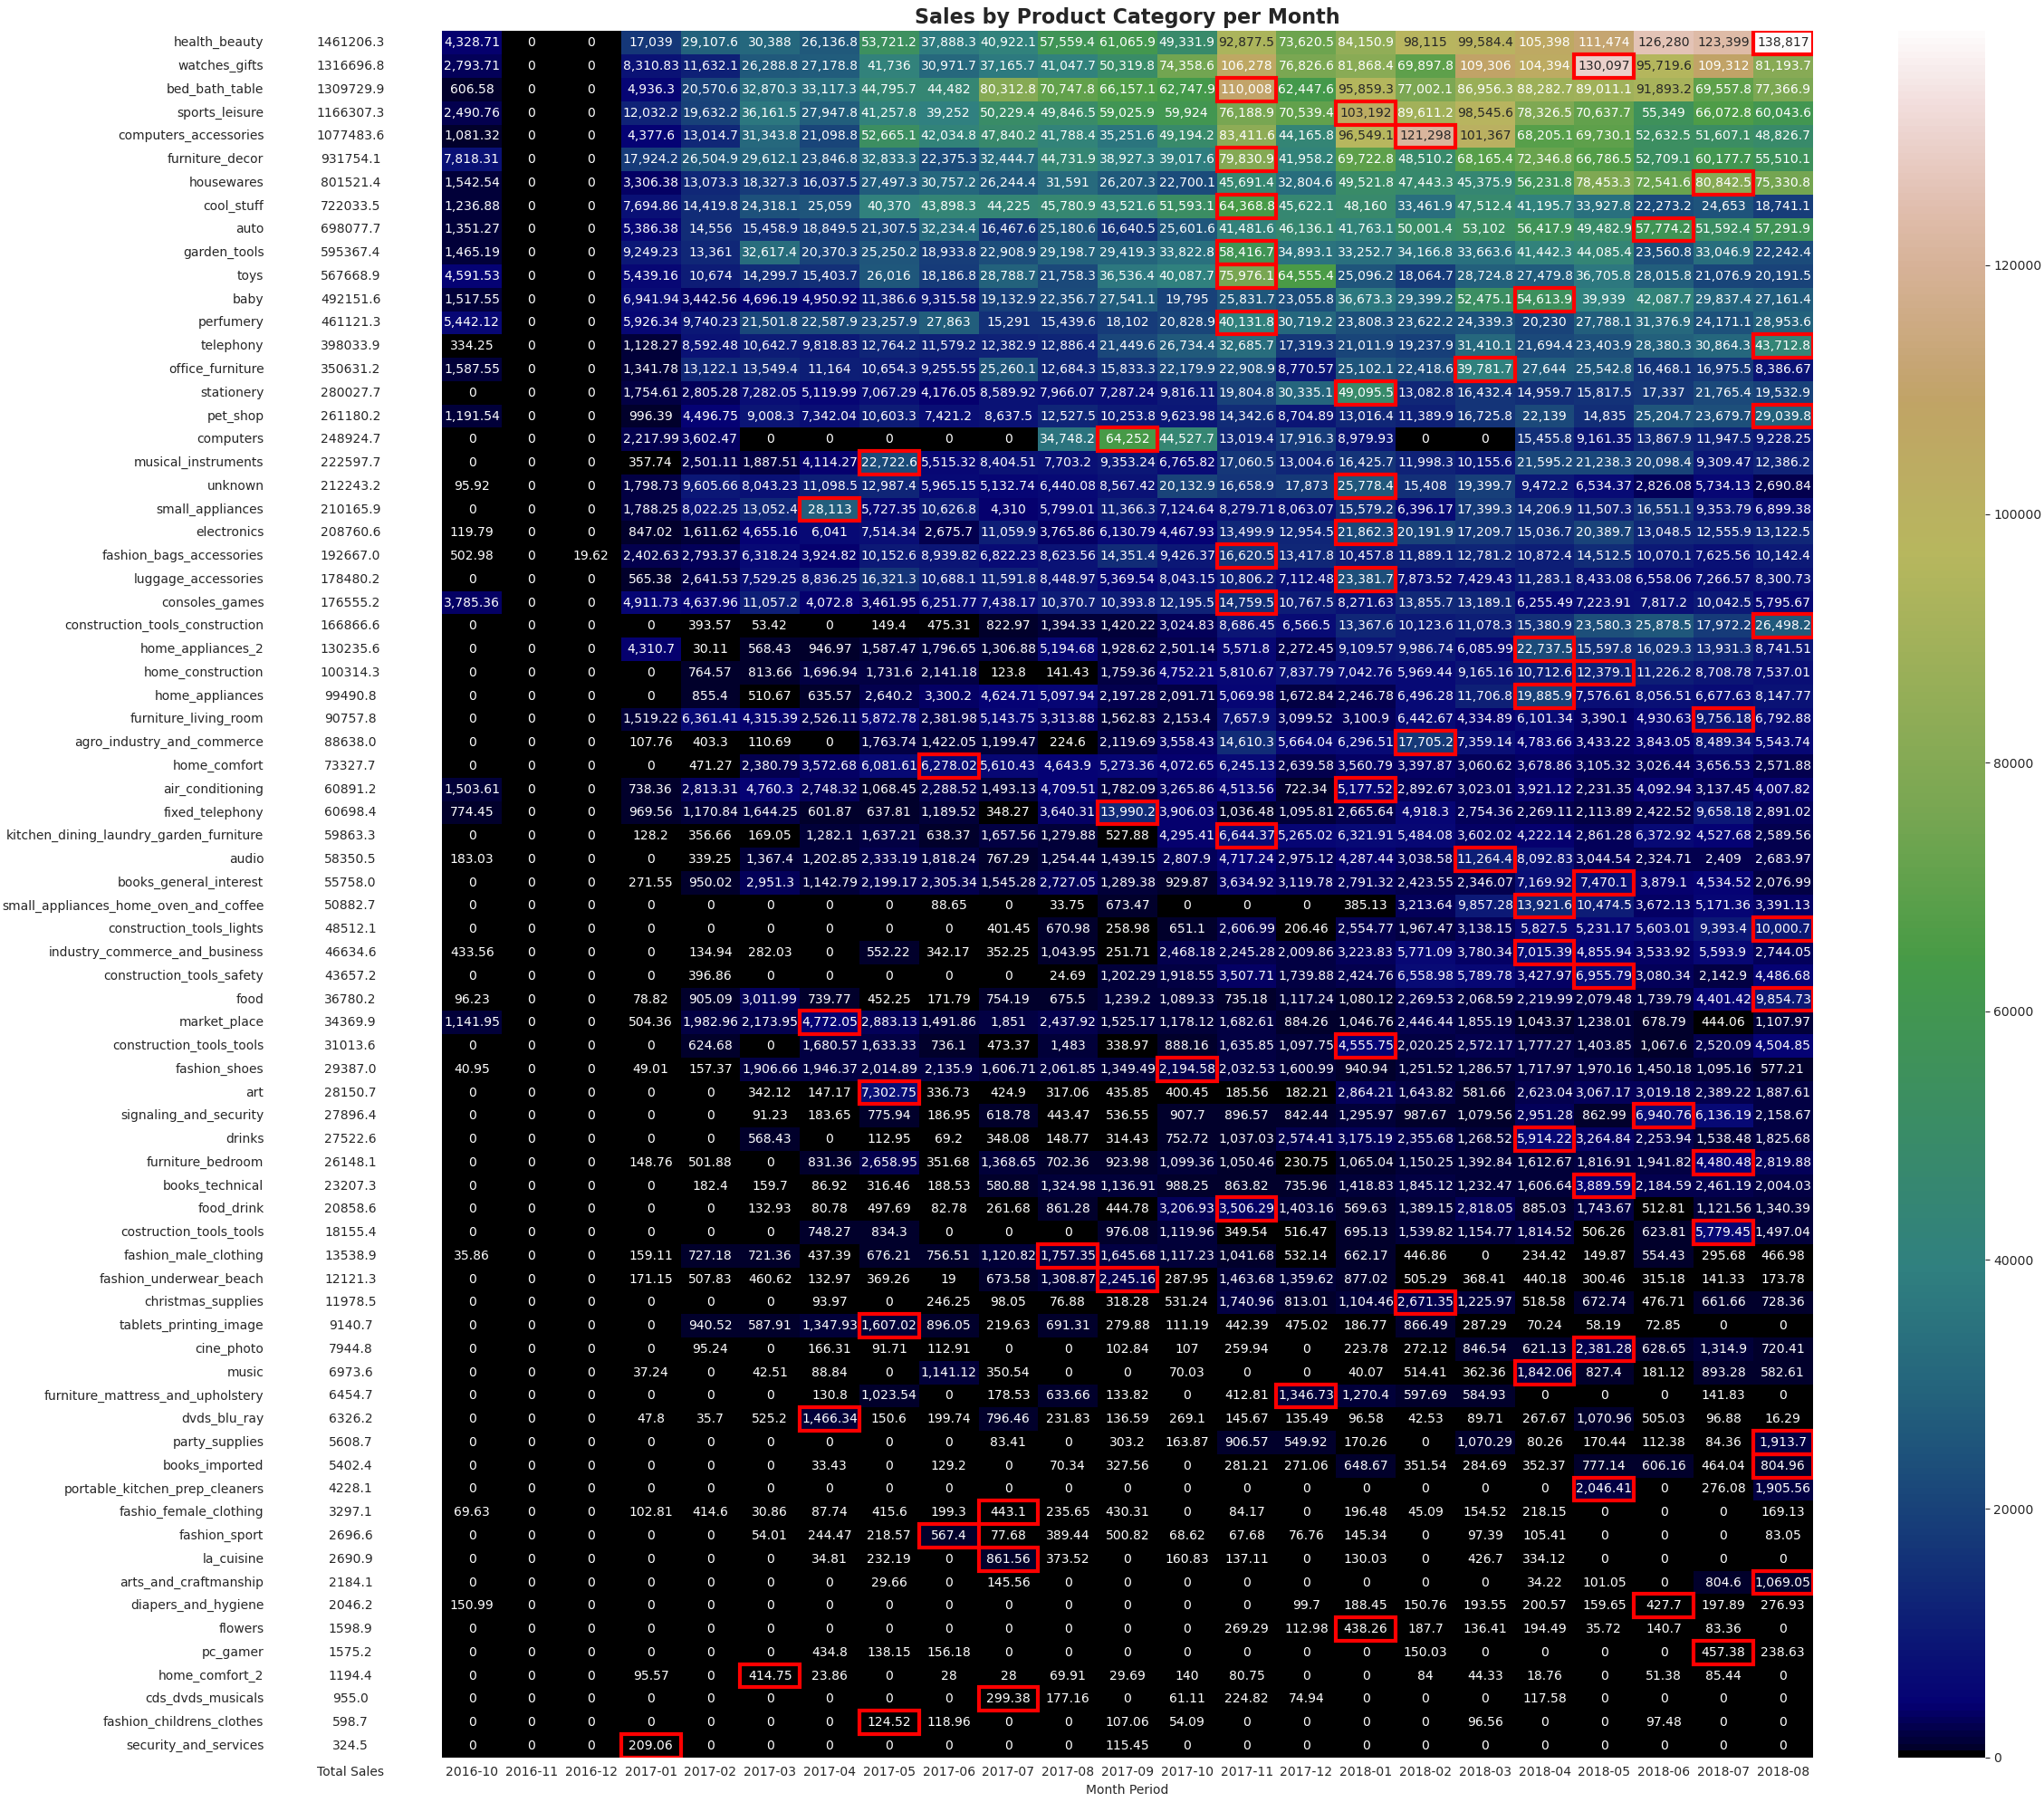

In [50]:
#### (4) Visualize heatmap with (1) and (2)

with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(24, 20),
        sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # Product Category per Month
    sns.heatmap(sales_by_product_ctg_per_month_pivot,
        annot=True, annot_kws={'ha': 'center', 'va': 'center'},
        fmt=',G', cmap='gist_earth', ax=ax[1])
    ax[1].set_title(
        'Sales by Product Category per Month', 
        fontsize=16, fontweight='bold')
    ax[1].set(xlabel='Month Period', ylabel='')
    
    # Highlighting highest number of order per product category
    row_max = sales_by_product_ctg_per_month_pivot.idxmax(axis=1)
    ## Add 2nd max if necessary
    # row_max_2 = (
    # sales_by_product_ctg_per_month_pivot.mask(
    #   sales_by_product_ctg_per_month_pivot.eq(
    #     sales_by_product_ctg_per_month_pivot.max(axis=1), axis=0)
    # ).idxmax(axis=1))
    
    for row, index in enumerate(
        sales_by_product_ctg_per_month_pivot.index):
        
        position_1 = (
            sales_by_product_ctg_per_month_pivot
                .columns.get_loc(row_max[index]))
        ax[1].add_patch(Rectangle((position_1, row),
            1, 1, fill=False, edgecolor='red', lw=3))
        
        # position_2 = (
        #     sales_by_product_ctg_per_month_pivot
        #         .columns.get_loc(row_max_2[index]))
        # ax[1].add_patch(Rectangle((position_2, row),
        #     1, 1, fill=False, edgecolor='red', lw=3))

    white_cmap = mcolors.ListedColormap(['white'])
        
    # Total Order by Product Category
    sns.heatmap(total_sales_by_product_ctg, 
        annot=True, cbar=False, fmt='.1f', 
        cmap=white_cmap, ax=ax[0])
        
    fig.tight_layout()

In [51]:
sales_by_product_ctg_per_month_pivot.T

product_category_name_english  health_beauty  watches_gifts  bed_bath_table  \
order_purchase_timestamp                                                      
2016-10                              4328.71        2793.71          606.58   
2016-11                                 0.00           0.00            0.00   
2016-12                                 0.00           0.00            0.00   
2017-01                             17038.97        8310.83         4936.30   
2017-02                             29107.58       11632.12        20570.57   
2017-03                             30388.04       26288.78        32870.27   
2017-04                             26136.82       27178.84        33117.26   
2017-05                             53721.22       41735.99        44795.68   
2017-06                             37888.32       30971.66        44482.02   
2017-07                             40922.10       37165.67        80312.79   
2017-08                             57559.45       41047.74        70747.84   
2017-09                             61065.94       50319.75        66157.13   
2017-10                             49331.91       74358.58        62747.93   
2017-11                             92877.50      106278.30       110008.38   
2017-12                             73620.50       76826.64        62447.62   
2018-01                             84150.85       81868.39        95859.30   
2018-02                             98114.99       69897.78        77002.15   
2018-03                             99584.45      109305.73        86956.30   
2018-04                            105397.78      104393.79        88282.70   
2018-05                            111474.49      130097.14        89011.11   
2018-06                            126280.50       95719.59        91893.21   
2018-07                            123399.45      109312.12        69557.78   
2018-08                            138816.72       81193.69        77366.93   

product_category_name_english  sports_leisure  computers_accessories  \
order_purchase_timestamp                                               
2016-10                               2490.76                1081.32   
2016-11                                  0.00                   0.00   
2016-12                                  0.00                   0.00   
2017-01                              12032.23                4377.60   
2017-02                              19632.25               13014.71   
2017-03                              36161.53               31343.82   
2017-04                              27947.85               21098.76   
2017-05                              41257.83               52665.12   
2017-06                              39252.02               42034.82   
2017-07                              50229.38               47840.18   
2017-08                              49846.47               41788.42   
2017-09                              59025.89               35251.58   
2017-10                              59924.03               49194.23   
2017-11                              76188.85               83411.61   
2017-12                              70539.44               44165.83   
2018-01                             103192.44               96549.12   
2018-02                              89611.18              121298.36   
2018-03                              98545.64              101366.65   
2018-04                              78326.53               68205.10   
2018-05                              70637.74               69730.12   
2018-06                              55348.97               52632.48   
2018-07                              66072.76               51607.14   
2018-08                              60043.55               48826.66   

product_category_name_english  furniture_decor  housewares  cool_stuff  \
order_purchase_timestamp                                                 
2016-10                                7818.31     1542.54     1236.88   
2

In [52]:
yoy_growth_by_prod_ctg = (
    sales_by_product_ctg_per_month_pivot.T -
    sales_by_product_ctg_per_month_pivot.T.shift(12)
) / sales_by_product_ctg_per_month_pivot.T.shift(12) * 100

# Replace NaN and inf values
yoy_growth_by_prod_ctg = yoy_growth_by_prod_ctg.replace(
    [np.inf, -np.inf, np.nan], 0)

## We'll only be taking values from Jan 18 - Aug 18, they seem stable
yoy_growth_by_prod_ctg = yoy_growth_by_prod_ctg

In [53]:
yoy_growth_by_prod_ctg

product_category_name_english  health_beauty  watches_gifts  bed_bath_table  \
order_purchase_timestamp                                                      
2016-10                             0.000000       0.000000        0.000000   
2016-11                             0.000000       0.000000        0.000000   
2016-12                             0.000000       0.000000        0.000000   
2017-01                             0.000000       0.000000        0.000000   
2017-02                             0.000000       0.000000        0.000000   
2017-03                             0.000000       0.000000        0.000000   
2017-04                             0.000000       0.000000        0.000000   
2017-05                             0.000000       0.000000        0.000000   
2017-06                             0.000000       0.000000        0.000000   
2017-07                             0.000000       0.000000        0.000000   
2017-08                             0.000000       0.000000        0.000000   
2017-09                             0.000000       0.000000        0.000000   
2017-10                          1039.644605    2561.642762    10244.543176   
2017-11                             0.000000       0.000000        0.000000   
2017-12                             0.000000       0.000000        0.000000   
2018-01                           393.872869     885.080792     1841.926139   
2018-02                           237.077112     500.903189      274.331630   
2018-03                           227.709355     315.788523      164.543918   
2018-04                           303.254030     284.099505      166.576100   
2018-05                           107.505507     211.714518       98.704674   
2018-06                           233.296647     209.055407      106.585065   
2018-07                           201.547208     194.121215      -13.391404   
2018-08                           141.171033      97.803070        9.355890   

product_category_name_english  sports_leisure  computers_accessories  \
order_purchase_timestamp                                               
2016-10                              0.000000               0.000000   
2016-11                              0.000000               0.000000   
2016-12                              0.000000               0.000000   
2017-01                              0.000000               0.000000   
2017-02                              0.000000               0.000000   
2017-03                              0.000000               0.000000   
2017-04                              0.000000               0.000000   
2017-05                              0.000000               0.000000   
2017-06                              0.000000               0.000000   
2017-07                              0.000000               0.000000   
2017-08                              0.000000               0.000000   
2017-09                              0.000000               0.000000   
2017-10                           2305.853234            4449.460844   
2017-11                              0.000000               0.000000   
2017-12                              0.000000               0.000000   
2018-01                            757.633539            2105.526316   
2018-02                            356.448853             832.009703   
2018-03                            172.515129             223.402349   
2018-04                            180.259591             223.265917   
2018-05                             71.210507              32.402850   
2018-06                             41.009227              25.211622   
2018-07                             31.542058               7.874051   
2018-08                             20.456975              16.842561   

product_category_name_english  furniture_decor   housewares   cool_stuff  \
order_purchase_timestamp                                                   
2016-10                               0.000000     0.000000     0.00000

In [54]:
sales_by_product_ctg_per_month_pivot.T.iloc[:, :10]

product_category_name_english  health_beauty  watches_gifts  bed_bath_table  \
order_purchase_timestamp                                                      
2016-10                              4328.71        2793.71          606.58   
2016-11                                 0.00           0.00            0.00   
2016-12                                 0.00           0.00            0.00   
2017-01                             17038.97        8310.83         4936.30   
2017-02                             29107.58       11632.12        20570.57   
2017-03                             30388.04       26288.78        32870.27   
2017-04                             26136.82       27178.84        33117.26   
2017-05                             53721.22       41735.99        44795.68   
2017-06                             37888.32       30971.66        44482.02   
2017-07                             40922.10       37165.67        80312.79   
2017-08                             57559.45       41047.74        70747.84   
2017-09                             61065.94       50319.75        66157.13   
2017-10                             49331.91       74358.58        62747.93   
2017-11                             92877.50      106278.30       110008.38   
2017-12                             73620.50       76826.64        62447.62   
2018-01                             84150.85       81868.39        95859.30   
2018-02                             98114.99       69897.78        77002.15   
2018-03                             99584.45      109305.73        86956.30   
2018-04                            105397.78      104393.79        88282.70   
2018-05                            111474.49      130097.14        89011.11   
2018-06                            126280.50       95719.59        91893.21   
2018-07                            123399.45      109312.12        69557.78   
2018-08                            138816.72       81193.69        77366.93   

product_category_name_english  sports_leisure  computers_accessories  \
order_purchase_timestamp                                               
2016-10                               2490.76                1081.32   
2016-11                                  0.00                   0.00   
2016-12                                  0.00                   0.00   
2017-01                              12032.23                4377.60   
2017-02                              19632.25               13014.71   
2017-03                              36161.53               31343.82   
2017-04                              27947.85               21098.76   
2017-05                              41257.83               52665.12   
2017-06                              39252.02               42034.82   
2017-07                              50229.38               47840.18   
2017-08                              49846.47               41788.42   
2017-09                              59025.89               35251.58   
2017-10                              59924.03               49194.23   
2017-11                              76188.85               83411.61   
2017-12                              70539.44               44165.83   
2018-01                             103192.44               96549.12   
2018-02                              89611.18              121298.36   
2018-03                              98545.64              101366.65   
2018-04                              78326.53               68205.10   
2018-05                              70637.74               69730.12   
2018-06                              55348.97               52632.48   
2018-07                              66072.76               51607.14   
2018-08                              60043.55               48826.66   

product_category_name_english  furniture_decor  housewares  cool_stuff  \
order_purchase_timestamp                                                 
2016-10                                7818.31     1542.54     1236.88   
2

In [55]:
## We're going to take the latest 8 months since
## these periods have both previous and current value--
## that's necessary for visualizing YoY sales growth

## And also we'll be taking top 10 profuct categories
## (the columns have already been sorted)
yoy_growth_by_prod_ctg.iloc[-8:, :10]

product_category_name_english  health_beauty  watches_gifts  bed_bath_table  \
order_purchase_timestamp                                                      
2018-01                           393.872869     885.080792     1841.926139   
2018-02                           237.077112     500.903189      274.331630   
2018-03                           227.709355     315.788523      164.543918   
2018-04                           303.254030     284.099505      166.576100   
2018-05                           107.505507     211.714518       98.704674   
2018-06                           233.296647     209.055407      106.585065   
2018-07                           201.547208     194.121215      -13.391404   
2018-08                           141.171033      97.803070        9.355890   

product_category_name_english  sports_leisure  computers_accessories  \
order_purchase_timestamp                                               
2018-01                            757.633539            2105.526316   
2018-02                            356.448853             832.009703   
2018-03                            172.515129             223.402349   
2018-04                            180.259591             223.265917   
2018-05                             71.210507              32.402850   
2018-06                             41.009227              25.211622   
2018-07                             31.542058               7.874051   
2018-08                             20.456975              16.842561   

product_category_name_english  furniture_decor   housewares  cool_stuff  \
order_purchase_timestamp                                                  
2018-01                             288.986851  1397.766439  525.872336   
2018-02                              83.023686   262.902002  132.055504   
2018-03                             130.194404   147.585930   95.379197   
2018-04                             203.381927   250.627531   64.394540   
2018-05                             103.410807   185.313155  -15.958055   
2018-06                             135.567922   135.852758  -49.261760   
2018-07                              85.477575   208.037140  -44.255534   
2018-08                              24.095070   138.456233  -59.063513   

product_category_name_english        auto  garden_tools  
order_purchase_timestamp                                 
2018-01                        675.345965    259.518144  
2018-02                        243.510481    155.720772  
2018-03                        243.504195      3.207462  
2018-04                        199.307884    103.444674  
2018-05                        132.232297     74.594696  
2018-06                         79.231702     24.437397  
2018-07                        213.296222     44.253495  
2018-08                        127.523978    -23.823903

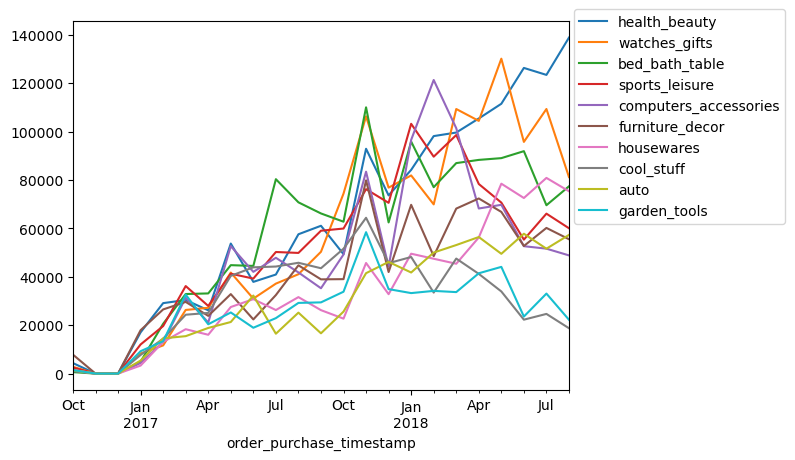

In [56]:
sales_by_product_ctg_per_month_pivot.T.iloc[:, :10].plot()
plt.legend(bbox_to_anchor=(1.45, 1.05))

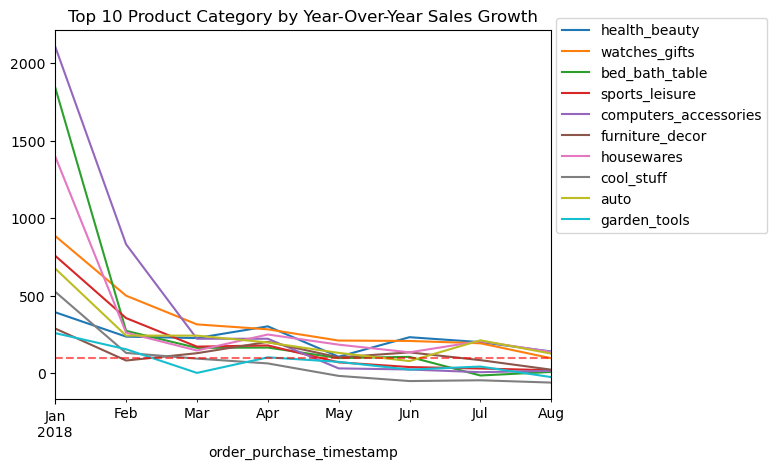

In [57]:
## YoY Sales Growth on Top 10 Product Categories in the latest 8 months
yoy_growth_by_prod_ctg.iloc[-8:, :10].plot(
    title=f'Top 10 Product Category by Year-Over-Year Sales Growth')
plt.axhline(y=100, color='r', linestyle='--', alpha=0.6)
plt.legend(bbox_to_anchor=(1.45, 1.05))

## Uncomment for making the graph below with the same x-axis scale
# plt.xlim([datetime.date(2016, 10, 1), datetime.date(2018, 8, 1)])

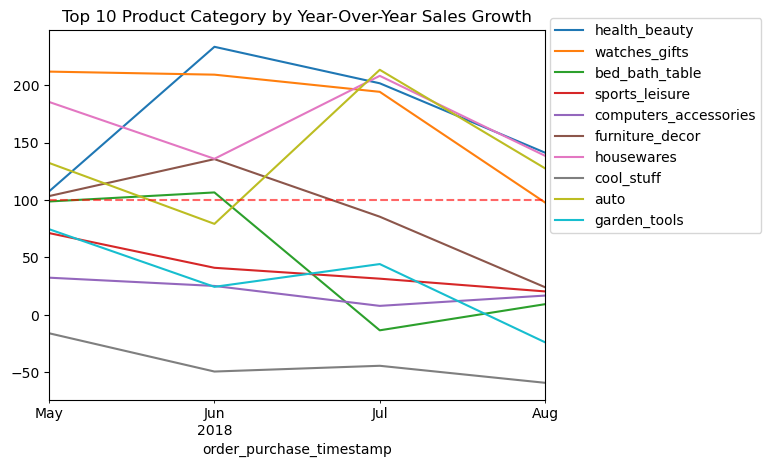

In [58]:
## Zooming in on the end:
yoy_growth_by_prod_ctg.iloc[-4:, :10].plot(
    title=f'Top 10 Product Category by Year-Over-Year Sales Growth')
plt.axhline(y=100, color='r', linestyle='--', alpha=0.6)
plt.legend(bbox_to_anchor=(1.45, 1.05))

From the graphs above, we found that:
- Most product category have a trend of sales going up from a rough average of `20,000 BRL` in Jan 2017 up to `22,000-138,000 BRL` in Aug 2018,
- A number of product categories have an increasing sales overtime such as `health_beauty`, `housewares`, and `auto`.
- The majority of product categories have a spike of total sales in Nov 2017
- Year-over-Year sales growth starts so high reaching `2000%` in Jan 2018, and goes down at the end reaching `300%` on Aug 2018.
- Several product categories show a decreasing sales growth touching the reference line of 100% as in steady sales growth, such as `cool_stuff`, `bed_bath_table` and `garden_tools`.

From our findings above we can suggest a number of recommendations:
- We can focus on the optimizing high-converting product categories based on the YoY sales growth such as `health_beauty`, `housewares`, `auto`, and `watches_gifts` by creating strategies for customer acquisition in the respective categories, OR/AND
- We can create strategies entailed to optimizing YoY sales growth on the remaining product categories, either ones that gets close to 100% (`furniture_decor`, `sports_leisure`, `computers_accessories`, `bed_bath_table`), or ones reacihing below 100% YoY growth sales (`garden_tools` and `cool_stuff`)

### Trends of Customers by States and Cities

In [59]:
df

order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4       47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
...                                  ...                               ...   
115715  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
115716  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
115717  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
115718  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
115719  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

       order_status order_purchase_timestamp   order_approved_at  \
0         delivered      2017-10-02 10:56:00 2017-10-02 11:07:00   
1         delivered      2017-10-02 10:56:00 2017-10-02 11:07:00   
2         delivered      2017-10-02 10:56:00 2017-10-02 11:07:00   
3         delivered      2018-07-24 20:41:00 2018-07-26 03:24:00   
4         delivered      2018-08-08 08:38:00 2018-08-08 08:55:00   
...             ...                      ...                 ...   
115715    delivered      2018-02-06 12:58:00 2018-02-06 13:10:00   
115716    delivered      2017-08-27 14:46:00 2017-08-27 15:04:00   
115717    delivered      2018-01-08 21:28:00 2018-01-08 21:36:00   
115718    delivered      2018-01-08 21:28:00 2018-01-08 21:36:00   
115719    delivered      2018-03-08 20:57:00 2018-03-09 11:20:00   

       order_delivered_carrier_date order_delivered_customer_date  \
0               2017-10-04 19:55:00           2017-10-10 21:25:00   
1               2017-10-04 19:55:00           2017-10-10 21:25:00   
2               2017-10-04 19:55:00           2017-10-10 21:25:00   
3               2018-07-26 14:31:00           2018-08-07 15:27:00   
4               2018-08-08 13:50:00           2018-08-17 18:06:00   
...                             ...                           ...   
115715          2018-02-07 23:22:00           2018-02-28 17:37:00   
115716          2017-08-28 20:52:00           2017-09-21 11:24:00   
115717          2018-01-12 15:35:00           2018-01-25 23:32:00   
115718          2018-01-12 15:35:00           2018-01-25 23:32:00   
115719          2018-03-09 22:11:00           2018-03-16 13:08:00   

       order_estimated_delivery_date  order_item_id  \
0                         2017-10-18            1.0   
1                         2017-10-18            1.0   
2                         2017-10-18            1.0   
3                         2018-08-13            1.0   
4                         2018-09-04            1.0   
...                              ...            ...   
115715                    2018-03-02            1.0   
115716                    2017-09-27            1.0   
115717                    2018-02-15            1.0   
115718                    2018-02-15            2.0   
115719                    2018-04-03            1.0   

                              product_id                         seller_id  \
0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
2       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
3       595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
4       aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
...                                  ...                               ...   
115715  f1d4ce8c6dd66c47bbaa8c6781c2a923  1f9ab4708f3056ede07124aad39a2554   
115716  b80910977a37536adeddd63663f916ad  d50d79cb34e38265a8649c383dcffd48   
115717  d1c427060a0f73f6b889a5c7c61f2ac4  a1043bafd471dff536d0c462352beb48   
115718  

In [60]:
total_sales_by_state = df.groupby('customer_state').agg(
    total_sales = ('total_sales', 'sum'),
    num_order   = ('order_item_id', 'count')
)

total_sales_by_state['total_sales_pct'] = (
    total_sales_by_state['total_sales'] / 
    total_sales_by_state['total_sales'].sum() * 100)

total_sales_by_state['num_order_pct'] = (
    total_sales_by_state['num_order'] / 
    total_sales_by_state['num_order'].sum() * 100)

In [61]:
total_sales_by_state.sort_values('total_sales', ascending=False)

total_sales  num_order  total_sales_pct  num_order_pct
customer_state                                                        
SP               6076295.43      48813        37.534327      42.181991
RJ               2167521.77      14963        13.389156      12.930349
MG               1890600.24      13496        11.678564      11.662634
RS                908920.14       6431         5.614557       5.557380
PR                812671.95       5894         5.020015       5.093329
BA                627081.41       3950         3.873590       3.413412
SC                616385.81       4239         3.807522       3.663152
DF                360530.87       2447         2.227061       2.114587
GO                355374.39       2395         2.195209       2.069651
ES                328955.10       2318         2.032012       2.003111
PE                321062.12       1840         1.983256       1.590045
CE                281430.06       1504         1.738442       1.299689
PA                219300.64       1097         1.354658       0.947978
MT                186000.71       1082         1.148959       0.935016
MA                151814.71        823         0.937786       0.711199
PB                148333.53        624         0.916282       0.539233
MS                139757.80        848         0.863308       0.732803
RN                113567.01        563         0.701523       0.486519
PI                111665.76        554         0.689779       0.478742
AL                 97724.79        445         0.603663       0.384549
SE                 72694.76        386         0.449048       0.333564
TO                 68355.46        334         0.422243       0.288628
RO                 58089.48        281         0.358829       0.242828
AM                 28298.78        170         0.174806       0.146906
AC                 20767.13         94         0.128282       0.081231
AP                 16396.40         83         0.101283       0.071725
RR                  9039.52         46         0.055839       0.039751

In [62]:
total_sales_by_state['total_sales'].mean()

599579.1025925926

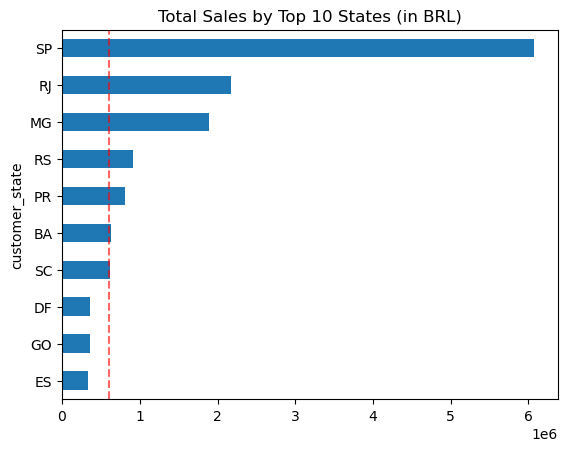

In [63]:
total_sales_by_state.sort_values(
    'total_sales', ascending=False)['total_sales'][:10].plot.barh(
    title='Total Sales by Top 10 States (in BRL)').invert_yaxis()
plt.axvline(x=total_sales_by_state['total_sales'].mean(),
            color='r', linestyle='--', alpha=0.6)

In [64]:
total_sales_by_state['num_order'].mean()

4285.925925925926

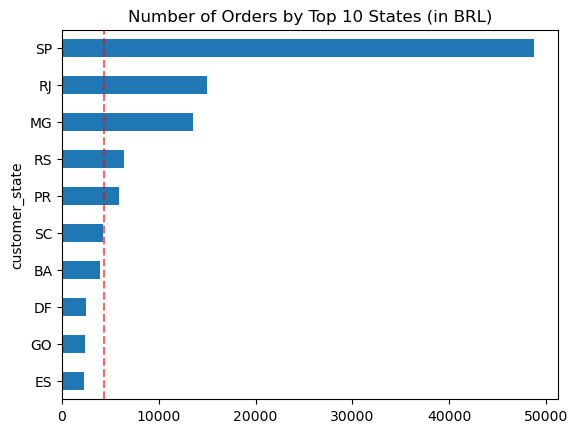

In [65]:
total_sales_by_state.sort_values(
    'num_order', ascending=False)['num_order'][:10].plot.barh(
    title='Number of Orders by Top 10 States (in BRL)').invert_yaxis()
plt.axvline(x=total_sales_by_state['num_order'].mean(),
            color='r', linestyle='--', alpha=0.6)

In [66]:
total_sales_by_city = df.groupby('customer_city').agg(
    total_sales = ('total_sales', 'sum'),
    num_order   = ('order_item_id', 'count')
)

total_sales_by_city['total_sales_pct'] = (
    total_sales_by_city['total_sales'] / 
    total_sales_by_city['total_sales'].sum() * 100)

total_sales_by_city['num_order_pct'] = (
    total_sales_by_city['num_order'] / 
    total_sales_by_city['num_order'].sum() * 100)

In [67]:
total_sales_by_city.index.nunique()

4085

In [68]:
total_sales_by_city

total_sales  num_order  total_sales_pct  num_order_pct
customer_city                                                              
abadia dos dourados       413.50          3         0.002554       0.002592
abadiania                1025.52          1         0.006335       0.000864
abaete                   1946.81         12         0.012026       0.010370
abaetetuba               4739.21         15         0.029275       0.012962
abaiara                   332.15          2         0.002052       0.001728
...                          ...        ...              ...            ...
xinguara                 1608.51         10         0.009936       0.008642
xique-xique               230.56          3         0.001424       0.002592
zacarias                  229.85          2         0.001420       0.001728
ze doca                   878.92          5         0.005429       0.004321
zortea                    137.57          2         0.000850       0.001728

[4085 rows x 4 columns]

In [69]:
total_sales_by_city['total_sales'].mean()

3962.9463329253363

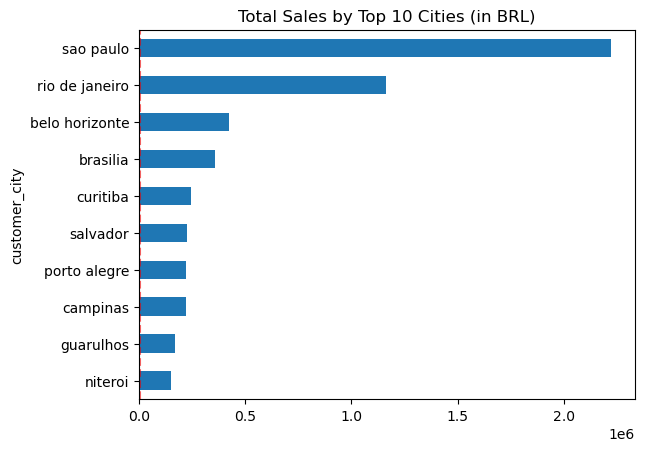

In [70]:
total_sales_by_city.sort_values(
    'total_sales', ascending=False)['total_sales'][:10].plot.barh(
    title='Total Sales by Top 10 Cities (in BRL)').invert_yaxis()
plt.axvline(x=total_sales_by_city['total_sales'].mean(),
            color='r', linestyle='--', alpha=0.6)

In [71]:
total_sales_by_city['num_order'].mean()

28.328029375764995

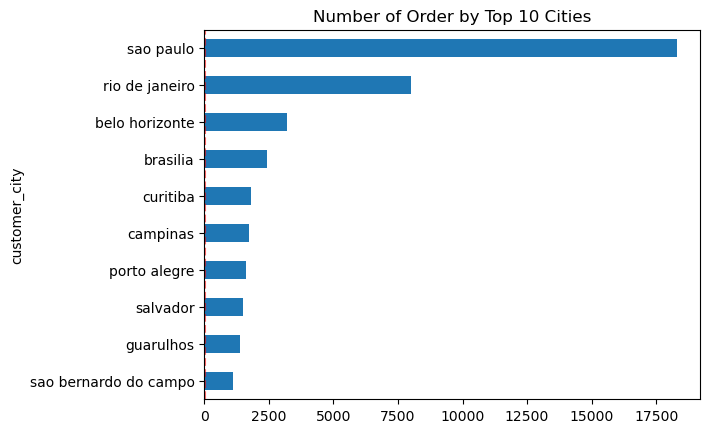

In [72]:
total_sales_by_city.sort_values(
    'num_order', ascending=False)['num_order'][:10].plot.barh(
    title='Number of Order by Top 10 Cities').invert_yaxis()
plt.axvline(x=total_sales_by_city['num_order'].mean(),
            color='r', linestyle='--', alpha=0.6)

In [73]:
## Highest Customers per Category by City
df_city_ctg = df.groupby(
    ['product_category_name_english', 'customer_city']
).agg(num_orders = ('customer_unique_id', 'count'))

df_city_ctg = (
    df_city_ctg.reset_index().pivot_table(
        index='customer_city',
        columns='product_category_name_english',
        values='num_orders', fill_value=0)
)

In [74]:
df_city_ctg

product_category_name_english  agro_industry_and_commerce  air_conditioning  \
customer_city                                                                 
abadia dos dourados                                     0                 0   
abadiania                                               0                 0   
abaete                                                  0                 0   
abaetetuba                                              0                 0   
abaiara                                                 0                 0   
...                                                   ...               ...   
xinguara                                                0                 0   
xique-xique                                             0                 0   
zacarias                                                0                 0   
ze doca                                                 0                 0   
zortea                                                  0                 0   

product_category_name_english  art  arts_and_craftmanship  audio  auto  baby  \
customer_city                                                                  
abadia dos dourados              0                      0      0     0     0   
abadiania                        0                      0      0     0     0   
abaete                           0                      0      0     0     1   
abaetetuba                       0                      0      0     2     0   
abaiara                          0                      0      0     1     0   
...                            ...                    ...    ...   ...   ...   
xinguara                         0                      0      1     0     0   
xique-xique                      0                      0      0     0     0   
zacarias                         0                      0      0     1     0   
ze doca                          0                      0      0     0     1   
zortea                           0                      0      0     0     0   

product_category_name_english  bed_bath_table  books_general_interest  \
customer_city                                                           
abadia dos dourados                         0                       1   
abadiania                                   0                       0   
abaete                                      1                       0   
abaetetuba                                  0                       0   
abaiara                                     0                       0   
...                                       ...                     ...   
xinguara                                    0                       0   
xique-xique                                 1                       0   
zacarias                                    0                       0   
ze doca                                     0                       0   
zortea                                      0                       0   

product_category_name_english  books_imported  books_technical  \
customer_city                                                    
abadia dos dourados                         0                0   
abadiania                                   0                0   
abaete                                      0                0   
abaetetuba                                  0                1   
abaiara                                     0                0   
...                                       ...              ...   
xinguara                                    0                0   
xique-xique                                 0                0   
zacarias                                    0                0   
ze doca                                     0                0   
zortea                                      0                0   

product_category_name_english  cds_dvds_musicals  christmas_supplies  \
customer_city                                     

In [75]:
df_city_per_ctg = pd.DataFrame(
    [df_city_ctg.idxmax(), df_city_ctg.max()])

df_city_per_ctg = df_city_per_ctg.T.reset_index().rename(
    columns={0: 'top_city', 1: 'num_customers'})

df_city_per_ctg = df_city_per_ctg.merge(df.value_counts(
        'product_category_name_english').reset_index(),
        on='product_category_name_english', how='left')

df_city_per_ctg['pct'] = (
    df_city_per_ctg['num_customers'] /
    df_city_per_ctg['count'] * 100)

In [76]:
df_city_per_ctg.sort_values('num_customers', ascending=False)[:10]

product_category_name_english   top_city num_customers  count        pct
7                 bed_bath_table  sao paulo          2163  11814  18.308786
43                 health_beauty  sao paulo          1769   9813  18.027107
67                sports_leisure  sao paulo          1429   8791  16.255261
49                    housewares  sao paulo          1374   7196  19.093941
39               furniture_decor  sao paulo          1340   8643  15.503876
15         computers_accessories  sao paulo          1229   7963  15.433882
73                 watches_gifts  sao paulo           848   6077  13.954254
71                          toys  sao paulo           664   4193  15.835917
70                     telephony  sao paulo           635   4607  13.783373
5                           auto  sao paulo           560   4302  13.017201

In [77]:
df_city_per_ctg.value_counts('top_city').reset_index()

top_city  count
0              sao paulo     63
1         rio de janeiro      3
2         belo horizonte      1
3               brasilia      1
4                  cotia      1
5                diadema      1
6                itapeva      1
7          montes claros      1
8            parauapebas      1
9  sao bernardo do campo      1

In [78]:
df_city_per_ctg.loc[df_city_per_ctg['top_city'] != 'sao paulo']

product_category_name_english               top_city num_customers  \
1                 air_conditioning         rio de janeiro            45   
3            arts_and_craftmanship                diadema             2   
23             diapers_and_hygiene                itapeva            10   
25                    dvds_blu_ray         rio de janeiro            10   
32                   fashion_sport            parauapebas             4   
52                      la_cuisine         belo horizonte             3   
55                           music         rio de janeiro             4   
58                  party_supplies  sao bernardo do campo             4   
59                        pc_gamer          montes claros             2   
62  portable_kitchen_prep_cleaners                  cotia             2   
63           security_and_services               brasilia             1   

    count        pct  
1     294  15.306122  
3      24   8.333333  
23     37  27.027027  
25     67  14.925373  
32     30  13.333333  
52     16      18.75  
55     40       10.0  
58     45   8.888889  
59      9  22.222222  
62     14  14.285714  
63      2       50.0

In [79]:
## Total percentage of transactions in São Paulo
(df.loc[df['customer_city'] == 'sao paulo', 'order_item_id'].count() / df.shape[0] * 100)

15.813169720013825

#### Insights: Trends by Cities

Based on the data analysis above, here's what we've found:

- Out of 29 states, we 5 states exceed both average total sales and average number of customers. `SP` (Sao Paulo) stands high with 6.076M BRL on 48,813 customers, followed by `RJ` (Rio de Janeiro) with 2.167M BRL on 14,963 customers, and `MG` (Minas Gerais) with 1.890M on 13,496 customers.

- Out of 1080 cities, we have top 10 cities that covers the majority of transactions. The top 10 cities far exceeds the average total sales of `3963 BRL` and the average total customers of `28.33 customers`. Top cities by highest transactions are `São Paulo`, followed by `Rio de Janeiro` and `Belo Horizonte`

- Out of 74 product categories, 63 of them (85.13%) have the majority of transactions in `São Paulo`, covering 15.81% of total customers in Olist.



## Trends in Marketing Funnel: `df_sellers`

In [80]:
df_sellers

mql_id first_contact_date  \
0     0b97be8b4b408a3a0780a32e0a143a7f         2018-01-22   
1     8257329475414b1eaf3dc731440e01a7         2018-01-30   
2     7b6ad2297d3beb569ddf3ee1ce22ffa8         2018-03-13   
3     327174d3648a2d047e8940d7d15204ca         2018-04-03   
4     8d6be534a8bdd08e11efe57c6ce3dd21         2018-04-05   
...                                ...                ...   
7995  8be61bb4942454f1fce2c9ff38c40ec3         2018-05-31   
7996  2edfbc33177d268d310968d775266d3f         2018-05-31   
7997  20b3a16b78ece9a01165504b7c0a1ace         2018-05-31   
7998  6649b621033ae95a2e9da0dd9c99fa48         2018-05-31   
7999  10bd89509a170e478e62697df43a5984         2018-05-31   

                       landing_page_id          origin  \
0     b76ef37428e6799c421989521c0e5077         unknown   
1     22c29808c4f815213303f8933030604c  organic_search   
2     22c29808c4f815213303f8933030604c     paid_search   
3     1ceb590cd1e00c7ee95220971f82693d  organic_search   
4     22c29808c4f815213303f8933030604c  organic_search   
...                                ...             ...   
7995  0b353d6bc27566f1d238313c33d95f56     paid_search   
7996  40dec9f3d5259a3d2dbcdab2114fae47     paid_search   
7997  35c9b150ab36fe584c1f24fd458c453a     paid_search   
7998  320669df6e03fc8a691a1a4c61c56a32         unknown   
7999  58326e62183c14b0c03085c33b9fdc44          social   

                             seller_id                            sdr_id  \
0     7d13fca15225358621be4086e1eb0964  56bf83c4bb35763a51c2baab501b4c67   
1     ba90964cff9b9e0e6f32b23b82465f7b  56bf83c4bb35763a51c2baab501b4c67   
2     c70c1b0d8ca86052f45a432a38b73958  9e4d1098a3b0f5da39b0bc48f9876645   
3     612170e34b97004b3ba37eae81836b4c  b90f87164b5f8c2cfa5c8572834dbe3f   
4     6061155addc1e54b4cfb51c1c2a32ad8  a8387c01a09e99ce014107505b92388c   
...                                ...                               ...   
7995                               NaN                               NaN   
7996                               NaN                               NaN   
7997                               NaN                               NaN   
7998                               NaN                               NaN   
7999                               NaN                               NaN   

                                 sr_id            won_date  business_segment  \
0     9ae085775a198122c5586fa830ff7f2b 2018-02-08 17:20:14           watches   
1     c638112b43f1d1b86dcabb0da720c901 2018-02-09 17:10:58  small_appliances   
2     060c0a26f19f4d66b42e0d8796688490 2018-03-13 21:39:34     health_beauty   
3     6565aa9ce3178a5caf6171827af3a9ba 2018-06-05 17:27:23   home_appliances   
4     2695de1affa7750089c0455f8ce27021 2018-04-27 20:44:40               pet   
...                                ...                 ...               ...   
7995                               NaN                 NaT               NaN   
7996                               NaN                 NaT               NaN   
7997                               NaN                 NaT               NaN   
7998                               NaN                 NaT               NaN   
7999                               NaN                 NaT               NaN   

          lead_type lead_behaviour_profile has_company has_gtin average_stock  \
0        online_big                unknown         NaN      NaN           NaN   
1             other                    cat         NaN      NaN           NaN   
2     online_medium                  shark         NaN      NaN           NaN   
3        online_big                    cat         NaN      NaN           NaN   
4      online_small                    cat         NaN      NaN           NaN   
...             ...                    ...         ...      ...           ...   
7995            NaN                    NaN         NaN      NaN           NaN   
7996            NaN                    NaN         NaN      NaN           NaN   

### Conversion Rate by Landing Pages

In [81]:
df_landing_pages = df_sellers.groupby('LP_index').agg(
    num_LP_records    = ('LP_index', 'count'),
    acquired_sellers  = ('seller_id', 'count'),
    total_sales       = ('total_sales', 'sum')    
).sort_values('total_sales', ascending=False)

# Landing Pages Conversion Rate
df_landing_pages['LP_conv_rate'] = df_landing_pages['acquired_sellers'] / df_landing_pages['num_LP_records'] * 100

## Customer (Sellers) Lifetime Value
df_landing_pages['sellers_CLV'] = df_landing_pages['total_sales'] / df_landing_pages['acquired_sellers']

## Total Sales in Percentage
df_landing_pages['total_sales_pct'] = (
    df_landing_pages['total_sales'] / 
    df_landing_pages['total_sales'].sum() * 100)

df_landing_pages['acquired_sellers_pct'] = (
    df_landing_pages['acquired_sellers'] / 
    df_landing_pages['acquired_sellers'].sum() * 100)

In [82]:
df_landing_pages

num_LP_records  acquired_sellers  total_sales  LP_conv_rate  \
LP_index                                                                
LP001                912               171    256159.92     18.750000   
LP002                883               174    195703.40     19.705549   
LP008                330                67     66321.59     20.303030   
LP005                394                59     38444.17     14.974619   
LP003                 71                 9     37080.64     12.676056   
...                  ...               ...          ...           ...   
LP211                  3                 0         0.00      0.000000   
LP210                  3                 0         0.00      0.000000   
LP209                 16                 0         0.00      0.000000   
LP208                  1                 0         0.00      0.000000   
LP495                  1                 0         0.00      0.000000   

          sellers_CLV  total_sales_pct  acquired_sellers_pct  
LP_index                                                      
LP001     1498.011228        31.809492             20.308789  
LP002     1124.732184        24.302107             20.665083  
LP008      989.874478         8.235699              7.957245  
LP005      651.596102         4.773930              7.007126  
LP003     4120.071111         4.604609              1.068884  
...               ...              ...                   ...  
LP211             NaN         0.000000              0.000000  
LP210             NaN         0.000000              0.000000  
LP209             NaN         0.000000              0.000000  
LP208             NaN         0.000000              0.000000  
LP495             NaN         0.000000              0.000000  

[495 rows x 7 columns]

In [83]:
df_landing_pages.index.nunique()

495

In [84]:
df_landing_pages['acquired_sellers'].mean()

1.701010101010101

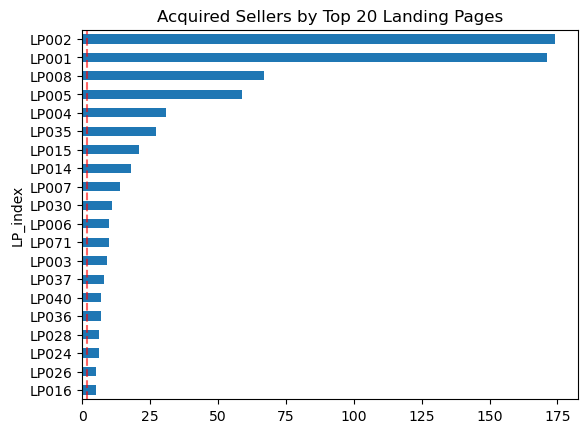

In [85]:
(df_landing_pages.sort_values('acquired_sellers', ascending=False)
    ['acquired_sellers'][:20].plot.barh(
        title='Acquired Sellers by Top 20 Landing Pages')
).invert_yaxis()
plt.axvline(x=df_landing_pages['acquired_sellers'].mean(),
            color='r', linestyle='--', alpha=0.6)

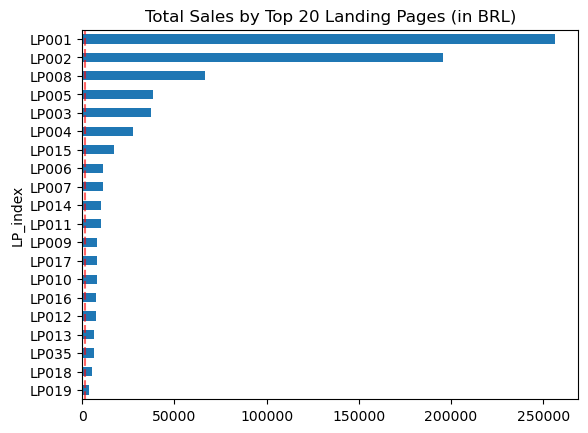

In [86]:
(df_landing_pages.sort_values('total_sales', ascending=False)
    ['total_sales'][:20].plot.barh(
        title='Total Sales by Top 20 Landing Pages (in BRL)')
).invert_yaxis()
plt.axvline(x=df_landing_pages['total_sales'].mean(),
            color='r', linestyle='--', alpha=0.6)

#### Insights: Landing Pages on Sellers Acquisition

From the graphs above, here's what we've found:

* Out of 495 landing pages, `LP001`, `LP002`, and `LP008`, and `LP005` dominates the sellers conversion and total sales, far exceeding the average in both acquired sellers and total sales. The top 4 landing pages cover:
    * acquired sellers of 20.31%, 20.66%, 7.96%, and 7.00% respectively, and
    * total sales of 31.81%, 24.30%, 8.24% and 4.77% respectively.
    
From our findings above we suggest to:
- focus on landing pages of `SR01`, `SR02`, `SR03`, `SR09`, and `SR10` for a better conversion of sellers in the future.

### Conversion Rate by Acquisition Channels

In [87]:
df_channels = df_sellers.groupby('origin').agg(
    num_LP_records    = ('LP_index', 'count'),
    acquired_sellers  = ('seller_id', 'count'),
    total_sales       = ('total_sales', 'sum')    
).sort_values('total_sales', ascending=False)

# Landing Pages Conversion Rate
df_channels['channel_conv_rate'] = df_channels['acquired_sellers'] / df_channels['num_LP_records'] * 100

## Customer (Sellers) Lifetime Value
df_channels['sellers_CLV'] = df_channels['total_sales'] / df_channels['acquired_sellers']

In [88]:
df_channels

num_LP_records  acquired_sellers  total_sales  \
origin                                                             
unknown                      1159               193    252532.32   
organic_search               2296               271    245892.46   
paid_search                  1586               195    184248.59   
social                       1350                75     56572.23   
direct_traffic                499                56     28462.39   
referral                      284                24     18539.63   
email                         493                15      9122.41   
other                         150                 4      8715.99   
display                       118                 6      1207.95   
other_publicities              65                 3         0.00   

                   channel_conv_rate  sellers_CLV  
origin                                             
unknown                    16.652286  1308.457617  
organic_search             11.803136   907.352251  
paid_search                12.295082   944.864564  
social                      5.555556   754.296400  
direct_traffic             11.222445   508.256964  
referral                    8.450704   772.484583  
email                       3.042596   608.160667  
other                       2.666667  2178.997500  
display                     5.084746   201.325000  
other_publicities           4.615385     0.000000

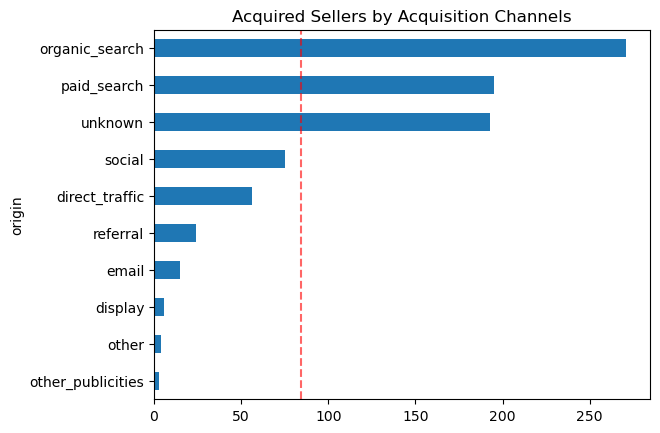

In [89]:
df_channels.sort_values('acquired_sellers', ascending=False
    )['acquired_sellers'].plot.barh(title=
    'Acquired Sellers by Acquisition Channels').invert_yaxis()
plt.axvline(x=df_channels['acquired_sellers'].mean(),
            color='r', linestyle='--', alpha=0.6)

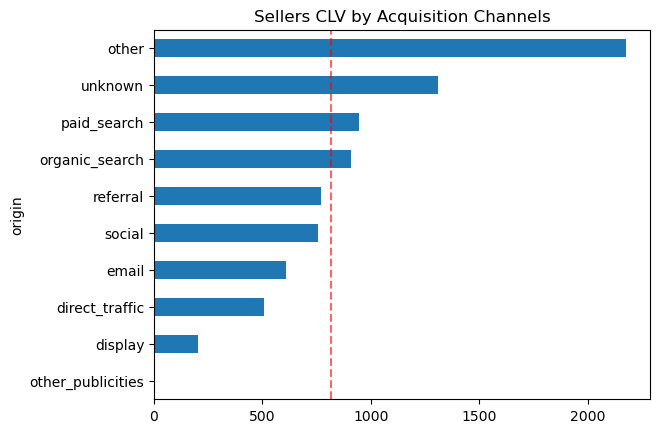

In [90]:
df_channels.sort_values('sellers_CLV', ascending=False
    )['sellers_CLV'].plot.barh(title=
    'Sellers CLV by Acquisition Channels').invert_yaxis()
plt.axvline(x=df_channels['sellers_CLV'].mean(),
            color='r', linestyle='--', alpha=0.6)

In [91]:
df_channels['channel_conv_rate'].mean()

8.138860237388913

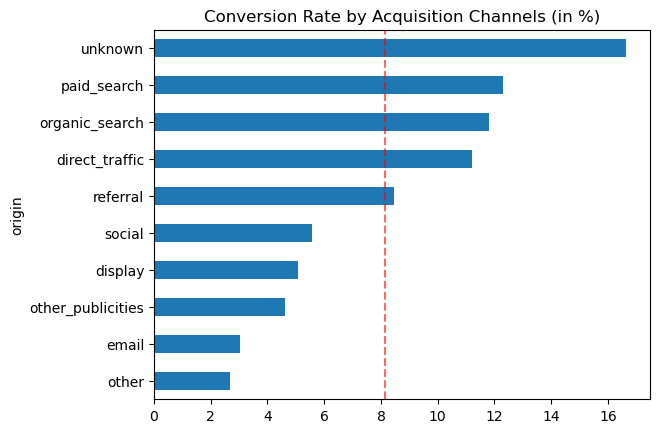

In [92]:
df_channels.sort_values('channel_conv_rate', ascending=False
    )['channel_conv_rate'].plot.barh(title=
    'Conversion Rate by Acquisition Channels (in %)').invert_yaxis()
plt.axvline(x=df_channels['channel_conv_rate'].mean(),
            color='r', linestyle='--', alpha=0.6)

#### Insights: Channel Acquisition on Leads Conversion to Sellers

Based on the data above (excluding `unknown` and `other` since we can't map both channels to get actionable insights) we've found that:

- For channels that brings highest traction of sellers, `organic_search` stands high acquiring 271 sellers, followed by `paid_search` with 195 sellers, and `social` with 75 sellers.

- For channels with the highest bag in total sales per seller, `paid_search` stands high with average sellers CLV of 944.86 BRL / seller, followed by `organic_search` with 907.35 BRL/ seller, `referral` with 772.48 BRL / seller, and `social` with 754.30 BRL / seller.

- For channels with the highest conversion rate, `paid_search` stands high with conversion rate of 12.295%, followed by `organic_search` with 11.803%, `direct_trafic` with 11.222%, and `referral` with 8.451%

From our findings above we suggest to focus on:
- Mapping the `unknown` and `other` channels in the future for a better data and clear insights later on, and
- Focusing on the top 4 channels of `paid_search`, `organic_search`, `referral`, and `social` given that they generate a relatively higher seller conversion rate compared to other channels

### Sales Velocity by Sales Representative

Here's how a seller join Olist according to the dataset description:

1. Sign-up at a landing page.
2. Get contacted by a Sales development Representative (SDR), confirm some information and schedule a consultancy.
3. Consultancy is made by a Sales Representative (SR). The SR may close the deal (lead sign up) or lose the deal (led leaves without sign in)
4. Lead becomes a seller and starts building his catalog on Olist.
5. His products are published on marketplaces and ready to sell!

With this, sales reps are the one who closes the deal, and we'll evaluate the performance through the data. We'll use a metric of **sales velocity**, which is calculated by:

$$Sales Velocity = { Average  Deal  Size \over Average  Sales  Cycle} $$

In [93]:
df_sellers

mql_id first_contact_date  \
0     0b97be8b4b408a3a0780a32e0a143a7f         2018-01-22   
1     8257329475414b1eaf3dc731440e01a7         2018-01-30   
2     7b6ad2297d3beb569ddf3ee1ce22ffa8         2018-03-13   
3     327174d3648a2d047e8940d7d15204ca         2018-04-03   
4     8d6be534a8bdd08e11efe57c6ce3dd21         2018-04-05   
...                                ...                ...   
7995  8be61bb4942454f1fce2c9ff38c40ec3         2018-05-31   
7996  2edfbc33177d268d310968d775266d3f         2018-05-31   
7997  20b3a16b78ece9a01165504b7c0a1ace         2018-05-31   
7998  6649b621033ae95a2e9da0dd9c99fa48         2018-05-31   
7999  10bd89509a170e478e62697df43a5984         2018-05-31   

                       landing_page_id          origin  \
0     b76ef37428e6799c421989521c0e5077         unknown   
1     22c29808c4f815213303f8933030604c  organic_search   
2     22c29808c4f815213303f8933030604c     paid_search   
3     1ceb590cd1e00c7ee95220971f82693d  organic_search   
4     22c29808c4f815213303f8933030604c  organic_search   
...                                ...             ...   
7995  0b353d6bc27566f1d238313c33d95f56     paid_search   
7996  40dec9f3d5259a3d2dbcdab2114fae47     paid_search   
7997  35c9b150ab36fe584c1f24fd458c453a     paid_search   
7998  320669df6e03fc8a691a1a4c61c56a32         unknown   
7999  58326e62183c14b0c03085c33b9fdc44          social   

                             seller_id                            sdr_id  \
0     7d13fca15225358621be4086e1eb0964  56bf83c4bb35763a51c2baab501b4c67   
1     ba90964cff9b9e0e6f32b23b82465f7b  56bf83c4bb35763a51c2baab501b4c67   
2     c70c1b0d8ca86052f45a432a38b73958  9e4d1098a3b0f5da39b0bc48f9876645   
3     612170e34b97004b3ba37eae81836b4c  b90f87164b5f8c2cfa5c8572834dbe3f   
4     6061155addc1e54b4cfb51c1c2a32ad8  a8387c01a09e99ce014107505b92388c   
...                                ...                               ...   
7995                               NaN                               NaN   
7996                               NaN                               NaN   
7997                               NaN                               NaN   
7998                               NaN                               NaN   
7999                               NaN                               NaN   

                                 sr_id            won_date  business_segment  \
0     9ae085775a198122c5586fa830ff7f2b 2018-02-08 17:20:14           watches   
1     c638112b43f1d1b86dcabb0da720c901 2018-02-09 17:10:58  small_appliances   
2     060c0a26f19f4d66b42e0d8796688490 2018-03-13 21:39:34     health_beauty   
3     6565aa9ce3178a5caf6171827af3a9ba 2018-06-05 17:27:23   home_appliances   
4     2695de1affa7750089c0455f8ce27021 2018-04-27 20:44:40               pet   
...                                ...                 ...               ...   
7995                               NaN                 NaT               NaN   
7996                               NaN                 NaT               NaN   
7997                               NaN                 NaT               NaN   
7998                               NaN                 NaT               NaN   
7999                               NaN                 NaT               NaN   

          lead_type lead_behaviour_profile has_company has_gtin average_stock  \
0        online_big                unknown         NaN      NaN           NaN   
1             other                    cat         NaN      NaN           NaN   
2     online_medium                  shark         NaN      NaN           NaN   
3        online_big                    cat         NaN      NaN           NaN   
4      online_small                    cat         NaN      NaN           NaN   
...             ...                    ...         ...      ...           ...   
7995            NaN                    NaN         NaN      NaN           NaN   
7996            NaN                    NaN         NaN      NaN           NaN   

In [94]:
df_sellers.loc[df_sellers['sr_id'].notna() & df_sellers['won_date'].isna()] 

Empty DataFrame
Columns: [mql_id, first_contact_date, landing_page_id, origin, seller_id, sdr_id, sr_id, won_date, business_segment, lead_type, lead_behaviour_profile, has_company, has_gtin, average_stock, business_type, declared_product_catalog_size, declared_monthly_revenue, seller_zip_code_prefix, seller_city, seller_state, num_order, num_unique_customers, total_sales, total_payment_value, avg_review_score, sales_cycle_in_days, LP_index, SDR_index, SR_index]
Index: []

In [95]:
df_SR = df_sellers.groupby('SR_index').agg(
    num_SR_records   = ('SR_index', 'count'),
    total_sales      = ('total_sales', 'sum'),
    avg_sales_cycle  = ('sales_cycle_in_days', 'mean')
).sort_values('total_sales', ascending=False)

## Average Deal Size
df_SR['avg_deal_size'] = df_SR['total_sales'] / df_SR['num_SR_records']

## Sales Velocity
df_SR['sales_velocity'] = df_SR['avg_deal_size'] / df_SR['avg_sales_cycle']

In [96]:
df_SR.sort_values('sales_velocity', ascending=False)

num_SR_records  total_sales  avg_sales_cycle  avg_deal_size  \
SR_index                                                                
SR02                  36     78762.57        22.388889    2187.849167   
SR03                  32     62558.82        25.218750    1954.963125   
SR01                  51    157997.46        41.705882    3097.989412   
SR10                  24     24465.53        17.000000    1019.397083   
SR04                  74     59463.84        25.783784     803.565405   
SR09                  59     39922.09        21.966102     676.645593   
SR06                 133    119391.67        30.488722     897.681729   
SR07                  64     46246.91        33.703125     722.607969   
SR05                  59     45858.31        48.389831     777.259492   
SR14                  82     57809.63        46.646341     704.995488   
SR13                  24     19492.70        55.125000     812.195833   
SR11                  63     38489.46        48.619048     610.943810   
SR08                  53     30595.37        61.735849     577.271132   
SR16                  26      9572.93        96.653846     368.189615   
SR15                  10      5499.55       172.000000     549.955000   
SR12                  27      8968.21       122.333333     332.155926   
SR17                   9       141.15       180.555556      15.683333   
SR18                   6        57.77       214.333333       9.628333   
SR19                   7         0.00       234.000000       0.000000   
SR20                   1         0.00       175.000000       0.000000   
SR21                   1         0.00       321.000000       0.000000   
SR22                   1         0.00       306.000000       0.000000   

          sales_velocity  
SR_index                  
SR02           97.720310  
SR03           77.520223  
SR01           74.281834  
SR10           59.964534  
SR04           31.165535  
SR09           30.804082  
SR06           29.443075  
SR07           21.440385  
SR05           16.062455  
SR14           15.113629  
SR13           14.733711  
SR11           12.565935  
SR08            9.350663  
SR16            3.809363  
SR15            3.197413  
SR12            2.715171  
SR17            0.086862  
SR18            0.044922  
SR19            0.000000  
SR20            0.000000  
SR21            0.000000  
SR22            0.000000

In [97]:
df_SR['avg_deal_size'].mean()

732.68079298654

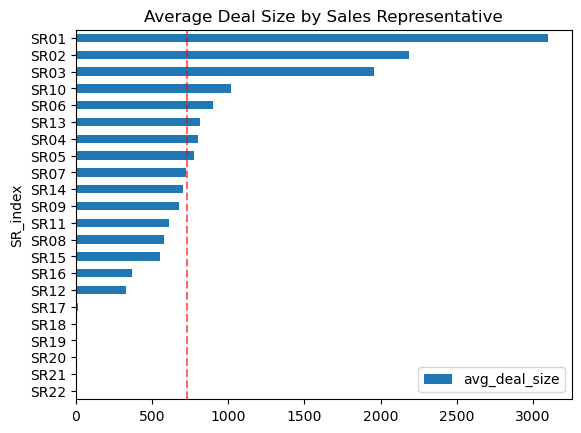

In [98]:
(df_SR.sort_values('avg_deal_size', ascending=False)
    ['avg_deal_size'].plot.barh(title=
    'Average Deal Size by Sales Representative').invert_yaxis())
plt.legend(loc='lower right')
plt.axvline(x=df_SR['avg_deal_size'].mean(),
            color='r', linestyle='--', alpha=0.6)

In [99]:
df_SR['avg_sales_cycle'].mean()

104.57488138857497

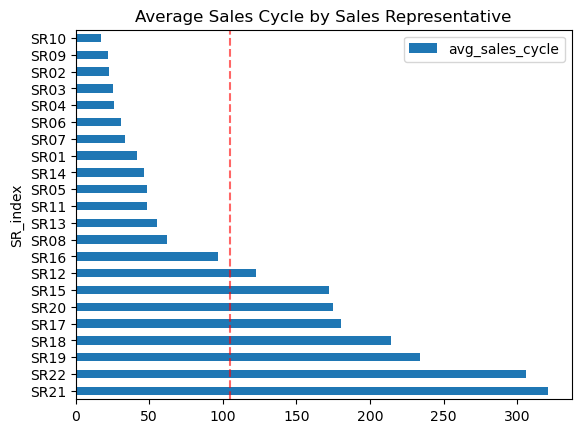

In [100]:
(df_SR.sort_values('avg_sales_cycle', ascending=True)
    ['avg_sales_cycle'].plot.barh(title=
    'Average Sales Cycle by Sales Representative').invert_yaxis())
plt.legend(loc='best')
plt.axvline(x=df_SR['avg_sales_cycle'].mean(),
            color='r', linestyle='--', alpha=0.6)

In [101]:
df_SR['sales_velocity'].mean()

22.728186470609025

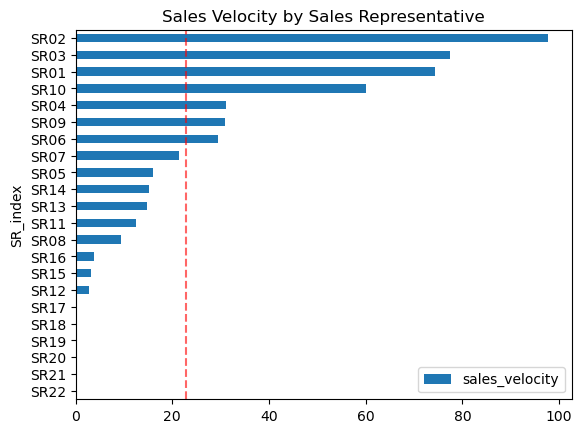

In [102]:
(df_SR.sort_values('sales_velocity', ascending=False)
    ['sales_velocity'].plot.barh(title=
    'Sales Velocity by Sales Representative').invert_yaxis())
plt.legend(loc='lower right')
plt.axvline(x=df_SR['sales_velocity'].mean(),
            color='r', linestyle='--', alpha=0.6)

#### Insights: Sales Representative

Based on the graphs above, here's what we've found:

- For sales reps that bags the most sales per seller, `SR01` has the highest value with average deal size of BRL 3,098 / seller, followed by `SR02` with 2,187 BRL / seller and `SR03` with 1,955 BRL / seller.
- For sales reps with the fastest to close the deal, `SR10` has the highest value with average sales cycle of 17.00 days, followed by `SR09` with 21.96 days and `SR02` with 22.39 days.
- For sales rep with the highest value of seller conversion, `SR02` has the highest sales velocity with 97.72 BRL / seller a day, followed with `SR03` with 77.52 BRL / seller a day, and `SR01`  with 74.08 BRL / seller a day.
- 7-8 sales reps exceeds each average of metrics in sales reps, with the average deal size of 732.68 BRL / seller, the average sales cycle of 104.575 day, and the average sales velocity of 22.728 BRL / seller a day.

From our findings above we suggest to:
- landing pages of `SR01`, `SR02`, `SR03`, `SR09`, and `SR10` for a better conversion of sellers in the future, and
- optimizing another sales reps that doesn't reach the target. We're only relying on the average of metrics, and have no further data explaining their performance, so with that we're recommending an approach of nurturing other sales reps with sharing session, workshop, or other strategies necessary.

### Marketing Funnel by Other Variables

In [103]:
df_sellers

mql_id first_contact_date  \
0     0b97be8b4b408a3a0780a32e0a143a7f         2018-01-22   
1     8257329475414b1eaf3dc731440e01a7         2018-01-30   
2     7b6ad2297d3beb569ddf3ee1ce22ffa8         2018-03-13   
3     327174d3648a2d047e8940d7d15204ca         2018-04-03   
4     8d6be534a8bdd08e11efe57c6ce3dd21         2018-04-05   
...                                ...                ...   
7995  8be61bb4942454f1fce2c9ff38c40ec3         2018-05-31   
7996  2edfbc33177d268d310968d775266d3f         2018-05-31   
7997  20b3a16b78ece9a01165504b7c0a1ace         2018-05-31   
7998  6649b621033ae95a2e9da0dd9c99fa48         2018-05-31   
7999  10bd89509a170e478e62697df43a5984         2018-05-31   

                       landing_page_id          origin  \
0     b76ef37428e6799c421989521c0e5077         unknown   
1     22c29808c4f815213303f8933030604c  organic_search   
2     22c29808c4f815213303f8933030604c     paid_search   
3     1ceb590cd1e00c7ee95220971f82693d  organic_search   
4     22c29808c4f815213303f8933030604c  organic_search   
...                                ...             ...   
7995  0b353d6bc27566f1d238313c33d95f56     paid_search   
7996  40dec9f3d5259a3d2dbcdab2114fae47     paid_search   
7997  35c9b150ab36fe584c1f24fd458c453a     paid_search   
7998  320669df6e03fc8a691a1a4c61c56a32         unknown   
7999  58326e62183c14b0c03085c33b9fdc44          social   

                             seller_id                            sdr_id  \
0     7d13fca15225358621be4086e1eb0964  56bf83c4bb35763a51c2baab501b4c67   
1     ba90964cff9b9e0e6f32b23b82465f7b  56bf83c4bb35763a51c2baab501b4c67   
2     c70c1b0d8ca86052f45a432a38b73958  9e4d1098a3b0f5da39b0bc48f9876645   
3     612170e34b97004b3ba37eae81836b4c  b90f87164b5f8c2cfa5c8572834dbe3f   
4     6061155addc1e54b4cfb51c1c2a32ad8  a8387c01a09e99ce014107505b92388c   
...                                ...                               ...   
7995                               NaN                               NaN   
7996                               NaN                               NaN   
7997                               NaN                               NaN   
7998                               NaN                               NaN   
7999                               NaN                               NaN   

                                 sr_id            won_date  business_segment  \
0     9ae085775a198122c5586fa830ff7f2b 2018-02-08 17:20:14           watches   
1     c638112b43f1d1b86dcabb0da720c901 2018-02-09 17:10:58  small_appliances   
2     060c0a26f19f4d66b42e0d8796688490 2018-03-13 21:39:34     health_beauty   
3     6565aa9ce3178a5caf6171827af3a9ba 2018-06-05 17:27:23   home_appliances   
4     2695de1affa7750089c0455f8ce27021 2018-04-27 20:44:40               pet   
...                                ...                 ...               ...   
7995                               NaN                 NaT               NaN   
7996                               NaN                 NaT               NaN   
7997                               NaN                 NaT               NaN   
7998                               NaN                 NaT               NaN   
7999                               NaN                 NaT               NaN   

          lead_type lead_behaviour_profile has_company has_gtin average_stock  \
0        online_big                unknown         NaN      NaN           NaN   
1             other                    cat         NaN      NaN           NaN   
2     online_medium                  shark         NaN      NaN           NaN   
3        online_big                    cat         NaN      NaN           NaN   
4      online_small                    cat         NaN      NaN           NaN   
...             ...                    ...         ...      ...           ...   
7995            NaN                    NaN         NaN      NaN           NaN   
7996            NaN                    NaN         NaN      NaN           NaN   

#### Sellers' Location (City)

In [104]:
## Fix this. We'll only count the sales

sellers_by_city = df_sellers.groupby('seller_city').agg(
    num_sellers = ('seller_city', 'count'),
    avg_review_score = ('avg_review_score', 'mean'),
    sales_cycle_in_days = ('sales_cycle_in_days', 'mean'),
    num_orders = ('num_order', 'sum'),
    total_sales = ('total_sales', 'sum')
)

sellers_by_city['num_sellers_pct'] = (
    sellers_by_city['num_sellers'] / 
    sellers_by_city['num_sellers'].sum() * 100)

In [105]:
sellers_by_city.sort_values('num_sellers', ascending=False)

num_sellers  avg_review_score  sales_cycle_in_days  \
seller_city                                                          
sao paulo                88          4.301284            22.056818   
rio de janeiro           15          4.188466            32.933333   
guarulhos                12          4.172175            21.916667   
curitiba                  9          4.537425            40.444444   
ribeirao preto            8          4.002340            33.125000   
...                     ...               ...                  ...   
lambari                   1          5.000000            16.000000   
jundiai                   1          4.583333            16.000000   
juiz de fora              1          4.500000             0.000000   
cotia                     1          4.636364            11.000000   
marilia                   1          4.800000             3.000000   

                num_orders  total_sales  num_sellers_pct  
seller_city                                               
sao paulo           1060.0    124663.11        23.157895  
rio de janeiro       385.0     46839.38         3.947368  
guarulhos            321.0     76928.79         3.157895  
curitiba              69.0      7270.36         2.368421  
ribeirao preto       662.0    140437.76         2.105263  
...                    ...          ...              ...  
lambari                2.0       225.61         0.263158  
jundiai               12.0       805.65         0.263158  
juiz de fora           8.0      5465.49         0.263158  
cotia                 22.0       593.45         0.263158  
marilia                5.0       269.91         0.263158  

[166 rows x 6 columns]

In [106]:
sellers_by_city['num_sellers'].mean()

2.289156626506024

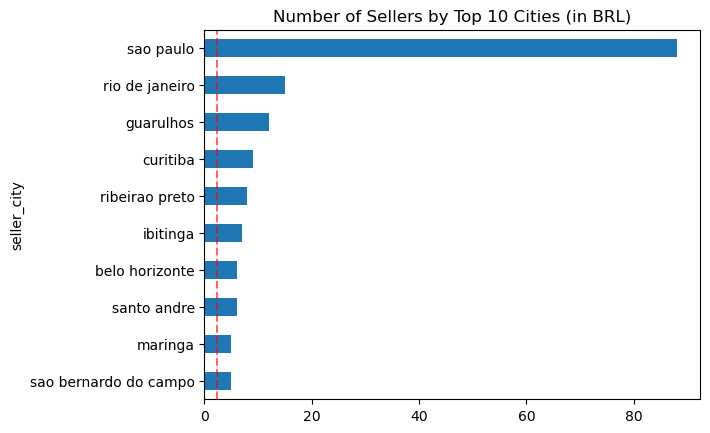

In [107]:
sellers_by_city.sort_values(
    'num_sellers', ascending=False)['num_sellers'][:10].plot.barh(
    title='Number of Sellers by Top 10 Cities (in BRL)').invert_yaxis()
plt.axvline(x=sellers_by_city['num_sellers'].mean(),
            color='r', linestyle='--', alpha=0.6)

#### Sellers' Business Type

In [108]:
sellers_by_business_type = df_sellers.groupby('business_type').agg(
      num_order = ('num_order', 'sum'),
    total_sales = ('total_sales', 'sum'),
    avg_review_score = ('avg_review_score', 'mean'),
    sales_cycle_in_days = ('sales_cycle_in_days', 'mean')
)

In [109]:
sellers_by_business_type

num_order  total_sales  avg_review_score  sales_cycle_in_days
business_type                                                               
manufacturer       706.0    101058.58          4.266682            45.417355
other                5.0      1301.21          4.333333            73.615385
reseller          4500.0    702934.18          4.311430            49.132879

#### Sellers' Lead Behaviour Profile

In [110]:
sellers_by_lead_behaviour_profile = df_sellers.groupby(
    'lead_behaviour_profile').agg(
          num_order = ('num_order', 'sum'),
        total_sales = ('total_sales', 'sum'),
        avg_review_score = ('avg_review_score', 'mean'),
        sales_cycle_in_days = ('sales_cycle_in_days', 'mean')
).sort_values('total_sales', ascending=False)

In [111]:
sellers_by_lead_behaviour_profile

num_order  total_sales  avg_review_score  \
lead_behaviour_profile                                             
cat                        1996.0    335717.37          4.262205   
unknown                    1795.0    275506.96          4.350674   
eagle                       760.0    111298.10          4.313219   
shark                       426.0     54861.78          4.243818   
wolf                        230.0     27135.43          4.338020   
eagle, cat                    3.0       696.01          4.666667   
cat, wolf                     1.0        78.32          5.000000   
eagle, wolf                   0.0         0.00               NaN   
shark, cat                    0.0         0.00               NaN   
shark, wolf                   0.0         0.00               NaN   

                        sales_cycle_in_days  
lead_behaviour_profile                       
cat                               40.700246  
unknown                           39.350282  
eagle                             35.975610  
shark                             75.375000  
wolf                              83.915789  
eagle, cat                       199.000000  
cat, wolf                        185.750000  
eagle, wolf                      149.333333  
shark, cat                       181.000000  
shark, wolf                      341.000000

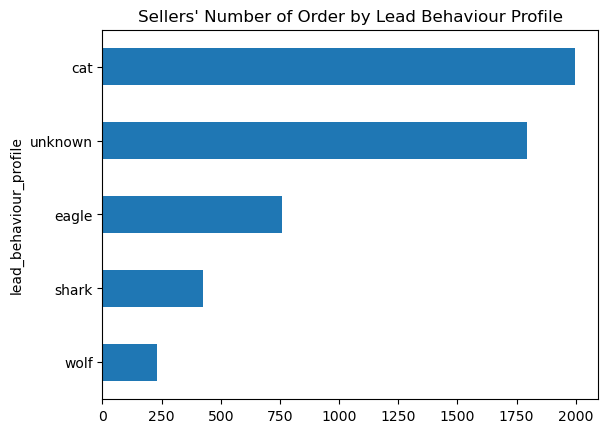

In [112]:
sellers_by_lead_behaviour_profile.iloc[:5, :]['num_order'].plot.barh(
    title="Sellers' Number of Order by Lead Behaviour Profile").invert_yaxis()

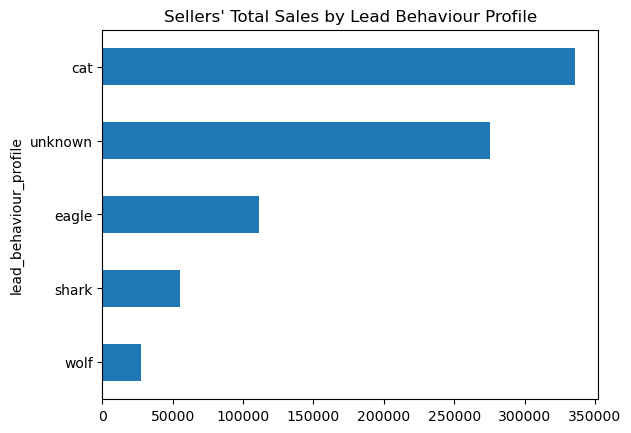

In [113]:
sellers_by_lead_behaviour_profile.iloc[:5, :]['total_sales'].plot.barh(
    title="Sellers' Total Sales by Lead Behaviour Profile").invert_yaxis()

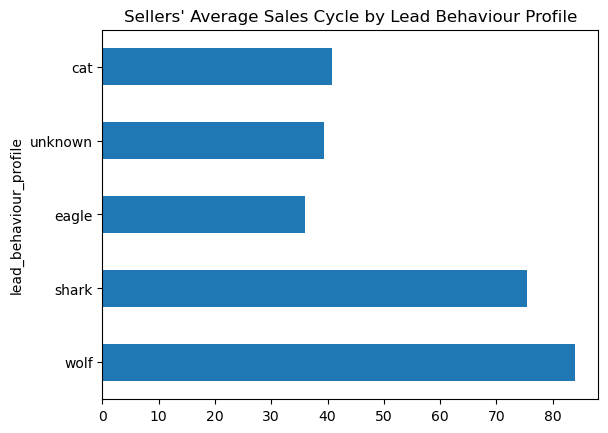

In [114]:
sellers_by_lead_behaviour_profile.iloc[:5, :]['sales_cycle_in_days'].plot.barh(
    title="Sellers' Average Sales Cycle by Lead Behaviour Profile").invert_yaxis()

#### Sellers' Business Segment

In [115]:
df_sellers['business_segment'].count() / df_sellers['business_segment'].nunique()

25.484848484848484

In [116]:
df_sellers['business_segment'].value_counts()

business_segment
home_decor                         105
health_beauty                       93
car_accessories                     77
household_utilities                 71
construction_tools_house_garden     69
audio_video_electronics             64
computers                           34
pet                                 30
food_supplement                     28
food_drink                          26
sports_leisure                      25
bed_bath_table                      22
bags_backpacks                      22
toys                                20
fashion_accessories                 19
home_office_furniture               14
stationery                          13
phone_mobile                        13
handcrafted                         12
small_appliances                    12
baby                                10
books                                9
music_instruments                    9
jewerly                              8
watches                              8
home_app

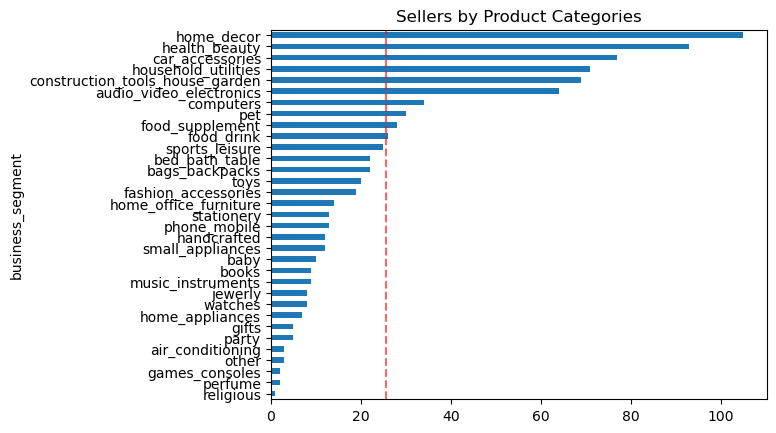

In [117]:
df_sellers['business_segment'].value_counts().plot.barh(
    title='Sellers by Product Categories').invert_yaxis()
plt.axvline(x=(df_sellers['business_segment'].count() / 
               df_sellers['business_segment'].nunique()),
            color='r', linestyle='--', alpha=0.6)

#### Insights: Other Variables in Marketing Funnel Data

From the graphs above, here's what we've found:

- The majority (88 or 23.16% total) of sellers are located within Sao Paulo city.

- 4,500 sellers are listed as reseller and 706 sellers are listed as manufacturer.

- The leads behavior profile according to data are classified into 4 main groups (excluding unknown): `cat`, `eagle`, `shark`, and `wolf`. By both total sales and average sales cycle, `cat` has the highest contributor with 335,717 BRL acquired within average of 40.7 days.

- The majority of sellers are in the product categories of `home_decor` with 105 sellers, followed by `health_beauty` with 93 sellers, `car_accessories` with 77 sellers, and `household_utilities` with 71 sellers.

- Compared to the total sales of top 20 product categories in the previous graphs, the product-market fit (PMF) checks out on a couple of categories such as `health_beauty`, `computers`, sports_leisure`, and `bed_bath_table`. 

- For another business segments, they don't seem totally match with the product categories--we're assuming that they could be clumped up inside another business segments. Some notable examples include `furniture_decor` and `housewares` in `home_decor`, `watches_gifts` in `watches`, or `computer_accessories` in `computers`.

# Outro

We've done data cleaning, we've done data analysis, and in the next section we'll create a dashboard so that we can have a platform of dashboard for ad-hoc analysis and insights. For this we'll move into Tableau.